In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
#function to display values on charts
def show_values(axs, orient="v", space=.1):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
#function to print various messages
def printmsg(x):
    print("------------------------")
    print("\n", x)
    print("\n------------------------")

In [3]:
df_train = pd.read_csv("train.csv")
df_train.head()
df_weather = pd.read_csv("weather.csv")

In [4]:
#print(len(pd.unique(df_train.Latitude)))
#print(len(pd.unique(df_train.Longitude)))
#print(len(pd.unique(df_train.AddressNumberAndStreet)))
print(df_train.shape)
print(df_weather.shape)
df_train.head()

(10506, 12)
(2944, 22)


Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [5]:
print("info",df_train.info())
print("\n\nNulls\n", df_train.isnull().sum())
print("\n\nmissing val ?\n", df_train.isin(["?"]).sum(axis = 0))
print("\n\nmissing val -\n", df_train.isin(["-"]).sum(axis = 0))
print("\n\n\nData is clean")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null object
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 985.0+ KB
info None


Nulls
 Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude 

In [6]:
df_train["Date"] = pd.to_datetime(df_train["Date"])
#df_train.head()
print(df_train.Date.sort_values().head(1))
print(df_train.Date.sort_values().tail(1))

print("\n")
print(df_train["Date"].dt.year.unique())
print(df_train["Date"].dt.month.unique())

0   2007-05-29
Name: Date, dtype: datetime64[ns]
10505   2013-09-26
Name: Date, dtype: datetime64[ns]


[2007 2009 2011 2013]
[ 5  6  7  8  9 10]


In [7]:
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster

In [8]:
#function to generate a folium basemap
def generateBaseMap(default_location=[df_train['Latitude'].mean(), df_train['Longitude'].mean()], default_zoom_start=10):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start, prefer_canvas = True)
    return base_map
#generateBaseMap()
base_map = generateBaseMap()
mc = MarkerCluster()

In [9]:
coord_array = df_train[['Latitude', 'Longitude']].values
base_map.add_child(HeatMap(coord_array, radius=15))
base_map

In [10]:
#3 clusters appear on heatmap
#but they are clusters of tests not positives
addr_c = df_train.Address.value_counts()
wnv_perc = df_train.groupby("Address")["WnvPresent"].sum().sort_values(ascending = False)
addr_c = addr_c.to_frame().join(wnv_perc.to_frame())

addr_c = addr_c.rename(columns = 
                      {
                          "Address":"Sample",
                          "WnvPresent":"Wnv_sample"
                      })
addr_c["Wnv_percent"] = addr_c.Wnv_sample * 100 / addr_c.Sample
addr_c.sort_values(by = "Sample", ascending = False).head()

Sample  Wnv_sample  \
ORD Terminal 5, O'Hare International Airport, C...     750          66   
South Doty Avenue, Chicago, IL, USA                    542          41   
South Stony Island Avenue, Chicago, IL, USA            314          16   
4100 North Oak Park Avenue, Chicago, IL 60634, USA     185          18   
4200 West 127th Street, Alsip, IL 60803, USA           183           8   

                                                    Wnv_percent  
ORD Terminal 5, O'Hare International Airport, C...     8.800000  
South Doty Avenue, Chicago, IL, USA                    7.564576  
South Stony Island Avenue, Chicago, IL, USA            5.095541  
4100 North Oak Park Avenue, Chicago, IL 60634, USA     9.729730  
4200 West 127th Street, Alsip, IL 60803, USA           4.371585

In [11]:
addr_c.sort_values(by = "Wnv_percent", ascending = False).head()

Sample  Wnv_sample  \
6500 North Oak Park Avenue, Chicago, IL 60631, USA      31           6   
6000 North Avondale Avenue, Chicago, IL 60631, USA      24           4   
6000 West Roscoe Street, Chicago, IL 60634, USA         14           2   
7100 North Harlem Avenue, Chicago, IL 60631, USA        50           7   
6400 West Strong Street, Chicago, IL, USA               30           4   

                                                    Wnv_percent  
6500 North Oak Park Avenue, Chicago, IL 60631, USA    19.354839  
6000 North Avondale Avenue, Chicago, IL 60631, USA    16.666667  
6000 West Roscoe Street, Chicago, IL 60634, USA       14.285714  
7100 North Harlem Avenue, Chicago, IL 60631, USA      14.000000  
6400 West Strong Street, Chicago, IL, USA             13.333333

In [12]:
df_positive = df_train[(df_train['WnvPresent'].isin([1]))]
#df_positive.info()
df_positive.head()

Date                                         Address  \
553 2007-07-18  3800 East 115th Street, Chicago, IL 60617, USA   
603 2007-07-25             South Doty Avenue, Chicago, IL, USA   
611 2007-07-25             South Doty Avenue, Chicago, IL, USA   
618 2007-07-25             South Doty Avenue, Chicago, IL, USA   
660 2007-07-25             South Doty Avenue, Chicago, IL, USA   

                    Species  Block       Street  Trap  \
553  CULEX PIPIENS/RESTUANS     38   E 115TH ST  T215   
603  CULEX PIPIENS/RESTUANS     12   S DOTY AVE  T115   
611  CULEX PIPIENS/RESTUANS     12   S DOTY AVE  T115   
618           CULEX PIPIENS     12   S DOTY AVE  T115   
660           CULEX PIPIENS     12   S DOTY AVE  T115   

            AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
553  3800  E 115TH ST, Chicago, IL  41.686398 -87.531635                8   
603  1200  S DOTY AVE, Chicago, IL  41.673408 -87.599862                5   
611  1200  S DOTY AVE, Chicago, IL  41.673408 -87.599862                5   
618  1200  S DOTY AVE, Chicago, IL  41.673408 -87.599862                5   
660  1200  S DOTY AVE, Chicago, IL  41.673408 -87.599862                5   

     NumMosquitos  WnvPresent  
553            50           1  
603            50           1  
611            50           1  
618            50           1  
660            50           1

<AxesSubplot:title={'center':'Wnv percentage'}>

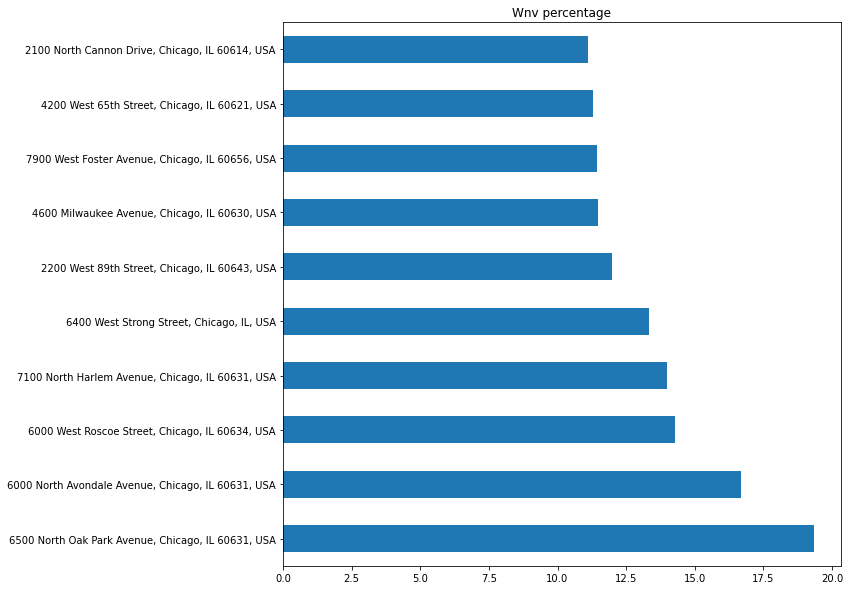

In [13]:
addr_c.Wnv_percent.sort_values(ascending = False).head(10).plot(kind = 
                                "barh", figsize = (10,10),
                                    title = "Wnv percentage")

In [14]:
base_map = generateBaseMap()
coord_array = df_positive[['Latitude', 'Longitude']].values
base_map.add_child(HeatMap(coord_array, radius=15))
base_map

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64


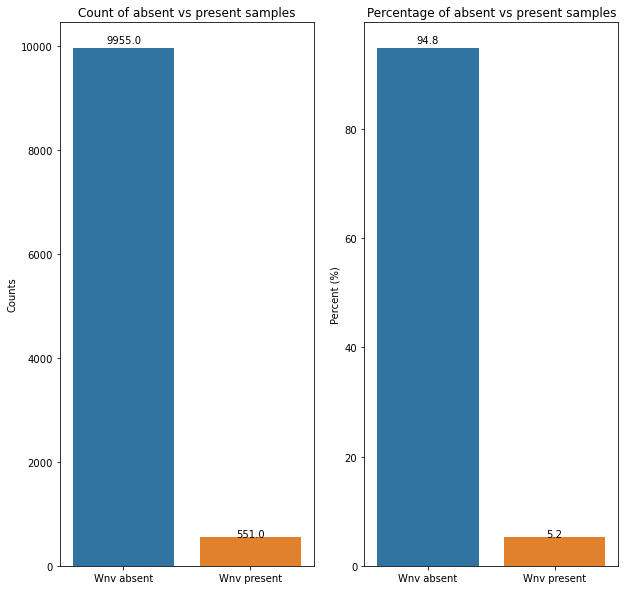

In [15]:
import seaborn as sns
sns.color_palette("tab10")
fig, ax = plt.subplots(1, 2, figsize = (10,10))
x = df_train.WnvPresent.replace(to_replace = [0, 1], 
                                value = ['Wnv absent', 'Wnv present'])

graph1 = sns.countplot(x = x, ax = ax[0])#, palette = "tab10")
graph1.set(ylabel = "Counts")
graph1.set(xlabel = None)
graph1.set(title = "Count of absent vs present samples")
show_values(graph1)

print(df_train.WnvPresent.value_counts()/len(df_train.WnvPresent))
y = x.value_counts()*100/len(df_train.WnvPresent)

graph2 = sns.barplot(x = ['Wnv absent', 'Wnv present'], y = y, ax = ax[1])
graph2.set(ylabel = "Percent (%)")
graph2.set(title = "Percentage of absent vs present samples")
show_values(graph2)

In [16]:
print("Unique species: ",df_train.Species.unique())
print("\nSpecies Counts\n",df_train.Species.value_counts())

Unique species:  ['CULEX PIPIENS/RESTUANS' 'CULEX RESTUANS' 'CULEX PIPIENS'
 'CULEX SALINARIUS' 'CULEX TERRITANS' 'CULEX TARSALIS' 'CULEX ERRATICUS']

Species Counts
 CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64


In [17]:
spec_c = df_train.Species.value_counts()
spec_wnv = df_train.groupby("Species")["WnvPresent"].sum().sort_values(ascending = False)
spec_c = spec_c.to_frame().join(spec_wnv.to_frame())
spec_c = spec_c.rename(columns = {
            "Species":"Sample",
            "WnvPresent":"Wnv_sample"
                    })
spec_c["Wnv_percent"]  = spec_c.Wnv_sample * 100 / spec_c.Sample
spec_c.reset_index(inplace = True)
spec_c = spec_c.rename(columns = {"index":"Species"})
spec_c.sort_values(by = "Wnv_percent", ascending = False)

Species  Sample  Wnv_sample  Wnv_percent
2           CULEX PIPIENS    2699         240     8.892182
0  CULEX PIPIENS/RESTUANS    4752         262     5.513468
1          CULEX RESTUANS    2740          49     1.788321
3         CULEX TERRITANS     222           0     0.000000
4        CULEX SALINARIUS      86           0     0.000000
5          CULEX TARSALIS       6           0     0.000000
6         CULEX ERRATICUS       1           0     0.000000

In [18]:
locs = df_train[["Latitude", "Longitude"]]
locs = locs.values.tolist()
#print(locs)

In [19]:
#removed:  much slower than px

#spec_map = generateBaseMap()
#m_c = MarkerCluster().add_to(map)
#for point in range(0, len(df_train)):
#    folium.Marker(locs[point], popup = 
#                 df_train['Species']).add_to(m_c)
#spec_map

In [144]:
import plotly.express as px
fig = px.scatter_mapbox(df_train,
                        lat = "Latitude", lon = "Longitude",
                        color = "Species",
                        hover_name = "Species",
                        color_discrete_sequence = px.colors.qualitative.Set1,
                        size_max = 20,
                        hover_data = [],
                        width = 900, height = 600,
                        title = "Species by location")
fig.update_layout(mapbox_style = "open-street-map")
fig.show()

In [145]:
fig = px.scatter_mapbox(df_positive,
                        lat = "Latitude", lon = "Longitude",
                        color = "Species",
                        hover_name = "Species",
                        color_discrete_sequence = px.colors.qualitative.Set1,
                        size_max = 20,
                        hover_data = [],
                        width = 900, height = 600,
                        title = "Positive locations by species")
fig.update_layout(mapbox_style = "open-street-map")
fig.show()

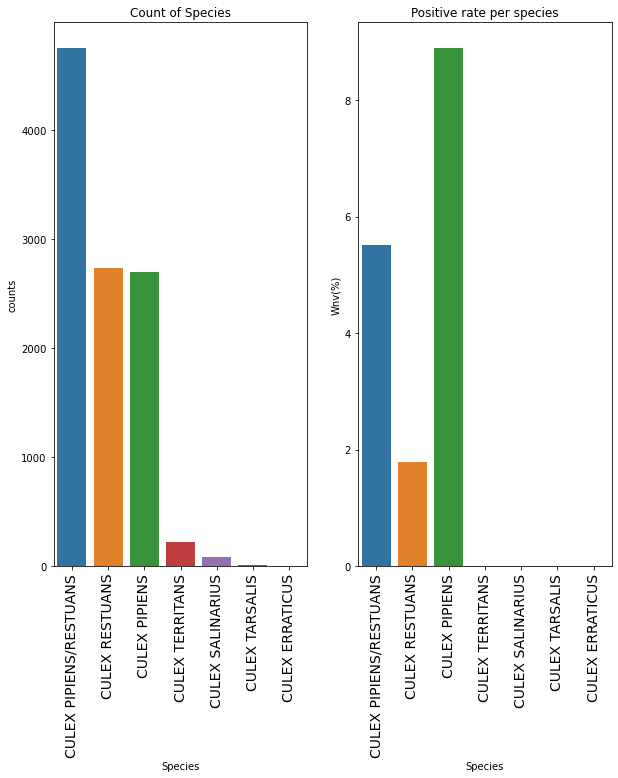

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (10, 10))
graph1 = sns.barplot(x = "Species", y = "Sample", data = spec_c, 
                     ax = ax[0])
graph1.set_xticklabels(graph1.get_xticklabels(), rotation = 90, size = 14)
graph1.set(ylabel = "counts")
graph1.set(title = "Count of Species")

graph2 = sns.barplot(x = "Species", y = "Wnv_percent", 
                    data = spec_c, ax = ax[1])
graph2.set_xticklabels(graph2.get_xticklabels(),
                      rotation = 90, size = 14)
graph2.set(ylabel = "Wnv(%)")
graph2.set(title = "Positive rate per species")
plt.show()

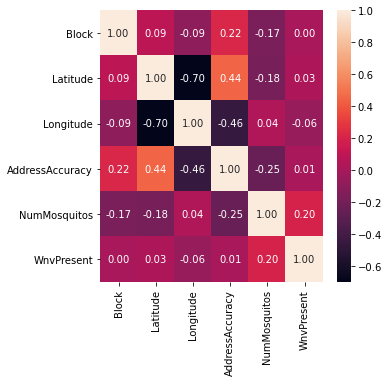

In [23]:
plt.subplots(figsize = (5,5))
corr = df_train.corr(method = "pearson")
ax = sns.heatmap(corr, annot = True, annot_kws = 
                {"size":10}, fmt = ".2f")

In [24]:
#start weather data
print(df_weather.shape)
print(df_weather.columns)
df_weather.head()

(2944, 22)
Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')


Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [25]:
print("info",df_weather.info())
print("\n\nNulls\n", df_weather.isnull().sum())
print("\n\nmissing val ?\n", df_weather.isin(["?"]).sum(axis = 0))
print("\n\nmissing val -\n", df_weather.isin(["-"]).sum(axis = 0))
print("\n\nmissing val -\n", df_weather.isin(["M"]).sum(axis = 0))
print("\n\n\nData is slightly dirty")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
Station        2944 non-null int64
Date           2944 non-null object
Tmax           2944 non-null int64
Tmin           2944 non-null int64
Tavg           2944 non-null object
Depart         2944 non-null object
DewPoint       2944 non-null int64
WetBulb        2944 non-null object
Heat           2944 non-null object
Cool           2944 non-null object
Sunrise        2944 non-null object
Sunset         2944 non-null object
CodeSum        2944 non-null object
Depth          2944 non-null object
Water1         2944 non-null object
SnowFall       2944 non-null object
PrecipTotal    2944 non-null object
StnPressure    2944 non-null object
SeaLevel       2944 non-null object
ResultSpeed    2944 non-null float64
ResultDir      2944 non-null int64
AvgSpeed       2944 non-null object
dtypes: float64(1), int64(5), object(16)
memory usage: 506.1+ KB
info None


Nulls
 Station        0
Date

In [26]:
df_weather["SnowFall"] = ["T" if i == "  T" else i for i in df_weather.SnowFall]
df_weather["SnowFall"] = ["T" if i == "M" else i for i in df_weather.SnowFall]
df_weather["SnowFall"] = ["F" if i == "0.0" else i for i in df_weather.SnowFall]
df_weather["SnowFall"] = ["T" if i == "0.1" else i for i in df_weather.SnowFall]
df_weather.SnowFall.value_counts()

T    1485
F    1459
Name: SnowFall, dtype: int64

In [27]:
df_weather["PrecipTotal"] = [0.001 if i == "  T" else i for i in df_weather.PrecipTotal]
#df_weather.PrecipTotal.value_counts()

In [28]:
df_w_stat1 = df_weather[df_weather["Station"] == 1]
df_w_stat2 = df_weather[df_weather["Station"] == 2]
df_w_stat1 = df_w_stat1.drop(columns = ["Station"], axis = 1)
df_w_stat2 = df_w_stat2.drop(columns = ["Station"], axis = 2)
df_w = df_w_stat1.merge(df_w_stat2, on = "Date")
df_w.head()

Date  Tmax_x  Tmin_x Tavg_x Depart_x  DewPoint_x WetBulb_x Heat_x  \
0  2007-05-01      83      50     67       14          51        56      0   
1  2007-05-02      59      42     51       -3          42        47     14   
2  2007-05-03      66      46     56        2          40        48      9   
3  2007-05-04      66      49     58        4          41        50      7   
4  2007-05-05      66      53     60        5          38        49      5   

  Cool_x Sunrise_x  ... CodeSum_y Depth_y Water1_y SnowFall_y PrecipTotal_y  \
0      2      0448  ...                 M        M          T          0.00   
1      0      0447  ...     BR HZ       M        M          T          0.00   
2      0      0446  ...        HZ       M        M          T          0.00   
3      0      0444  ...                 M        M          T          0.00   
4      0      0443  ...                 M        M          T         0.001   

  StnPressure_y SeaLevel_y ResultSpeed_y  ResultDir_y  AvgSpeed_y  
0         29.18      29.82           2.7           25         9.6  
1         29.44      30.08          13.3            2        13.4  
2         29.46      30.12          12.9            6        13.2  
3         29.36      30.04          10.1            7        10.4  
4         29.46      30.09          11.2            7        11.5  

[5 rows x 41 columns]

In [29]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 41 columns):
Date             1472 non-null object
Tmax_x           1472 non-null int64
Tmin_x           1472 non-null int64
Tavg_x           1472 non-null object
Depart_x         1472 non-null object
DewPoint_x       1472 non-null int64
WetBulb_x        1472 non-null object
Heat_x           1472 non-null object
Cool_x           1472 non-null object
Sunrise_x        1472 non-null object
Sunset_x         1472 non-null object
CodeSum_x        1472 non-null object
Depth_x          1472 non-null object
Water1_x         1472 non-null object
SnowFall_x       1472 non-null object
PrecipTotal_x    1472 non-null object
StnPressure_x    1472 non-null object
SeaLevel_x       1472 non-null object
ResultSpeed_x    1472 non-null float64
ResultDir_x      1472 non-null int64
AvgSpeed_x       1472 non-null object
Tmax_y           1472 non-null int64
Tmin_y           1472 non-null int64
Tavg_y           1472 no

In [30]:
df_w.isnull().sum()

Date             0
Tmax_x           0
Tmin_x           0
Tavg_x           0
Depart_x         0
DewPoint_x       0
WetBulb_x        0
Heat_x           0
Cool_x           0
Sunrise_x        0
Sunset_x         0
CodeSum_x        0
Depth_x          0
Water1_x         0
SnowFall_x       0
PrecipTotal_x    0
StnPressure_x    0
SeaLevel_x       0
ResultSpeed_x    0
ResultDir_x      0
AvgSpeed_x       0
Tmax_y           0
Tmin_y           0
Tavg_y           0
Depart_y         0
DewPoint_y       0
WetBulb_y        0
Heat_y           0
Cool_y           0
Sunrise_y        0
Sunset_y         0
CodeSum_y        0
Depth_y          0
Water1_y         0
SnowFall_y       0
PrecipTotal_y    0
StnPressure_y    0
SeaLevel_y       0
ResultSpeed_y    0
ResultDir_y      0
AvgSpeed_y       0
dtype: int64

In [31]:
df_w = df_w.drop(columns = ["CodeSum_x", "Depart_y", "Sunrise_y", "Sunset_y",
                           "CodeSum_y", "Depth_y"], axis = 1)

In [32]:
df_w["Sunrise"] = df_w["Sunrise_x"].map(lambda x: x[0:2] + ":" + x[2:4])
df_w["Sunrise"] = pd.to_datetime(df_w.Sunrise, format = "%H:%M") - pd.to_datetime("1900-01-01 00:00:00")
#df_w.Sunrise

In [33]:
df_w["Sunset"] = df_w["Sunset_x"].map(lambda x: x[0:2] + ":" + x[2:4])
df_w.Sunset_x.unique()

array(['1849', '1850', '1851', '1852', '1853', '1855', '1856', '1857',
       '1858', '1859', '1860', '1901', '1902', '1903', '1904', '1905',
       '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913',
       '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921',
       '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929',
       '1930', '1931', '1900', '1854', '1848', '1846', '1845', '1843',
       '1842', '1840', '1839', '1837', '1835', '1834', '1832', '1831',
       '1829', '1827', '1826', '1824', '1822', '1821', '1819', '1817',
       '1815', '1814', '1812', '1810', '1809', '1807', '1805', '1803',
       '1760', '1758', '1756', '1755', '1753', '1751', '1749', '1748',
       '1746', '1744', '1742', '1741', '1739', '1737', '1735', '1734',
       '1732', '1730', '1729', '1727', '1725', '1724', '1722', '1720',
       '1719', '1717', '1715', '1714', '1712', '1711', '1709', '1707',
       '1706', '1704', '1703', '1701', '1660', '1658', '1657', '1656',
      

In [34]:
df_w.Sunset_x.replace("1860", "1900", inplace = True)
df_w.Sunset_x.replace("1760", "1800", inplace = True)
df_w.Sunset_x.replace("1660", "1700", inplace = True)

df_w["Sunset"] = df_w["Sunset_x"].map(lambda x: x[0:2] + ":" + x[2:4])
df_w["Sunset"] = pd.to_datetime(df_w.Sunset, format = "%H:%M") - pd.to_datetime("1900-01-01 00:00:00")

In [35]:
#for i in range(0, len(df_w.WetBulb_x)):
#    if df_w.WetBulb_x[i] == "M":
#        df_w.WetBulb_x[i] = df_w["WetBulb_x"].mean()

df_w["WetBulb_x"] = [0 if i == "M" else i for i in df_w["WetBulb_x"]]
df_w["WetBulb_y"] = [0 if i == "M" else i for i in df_w["WetBulb_y"]]
df_w["Heat_y"] = [0 if i == "M" else i for i in df_w["Heat_y"]]
df_w["Cool_y"] = [0 if i == "M" else i for i in df_w["Cool_y"]]
df_w["Tavg_y"] = [0 if i == "M" else i for i in df_w["Tavg_y"]]
df_w.replace(to_replace = "M", value = 0, inplace = True)
df_w.WetBulb_x.value_counts()

65    68
63    66
59    63
61    61
64    60
60    58
67    56
62    55
70    55
69    54
56    54
66    53
57    52
58    51
55    50
68    48
71    43
52    39
46    37
53    36
50    29
72    29
49    28
47    28
54    28
45    28
73    27
48    26
51    25
74    25
44    22
42    20
43    17
40    14
41    11
38    11
39     8
75     8
76     6
35     4
36     4
33     3
34     3
0      3
77     2
37     2
78     1
32     1
Name: WetBulb_x, dtype: int64

In [36]:
df_w['Daytime_length']=(df_w['Sunset']-df_w['Sunrise']).astype(str)
df_w['Daytime_length']=round(df_w.Daytime_length.str.slice(7, 12, 1).str.split(':').apply(lambda x: (float(x[0])  + float(x[1])/60.0  )),2)

df_w[['Tavg_x', 'Depart_x', 'WetBulb_x', 'Heat_x', 'Cool_x',
                   'WetBulb_y', 'Heat_y', 'Cool_y','Tavg_y'] ]=df_w[['Tavg_x', 'Depart_x',
                   'WetBulb_x', 'Heat_x', 'Cool_x','WetBulb_y', 
                   'Heat_y', 'Cool_y','Tavg_y' ]].apply(pd.to_numeric)

df_w[['Depth_x', 'PrecipTotal_x','StnPressure_x', 'SeaLevel_x', 'AvgSpeed_x',
                   'PrecipTotal_y', 'StnPressure_y','SeaLevel_y', 'AvgSpeed_y'] ]=df_w[['Depth_x',
                    'PrecipTotal_x','StnPressure_x', 'SeaLevel_x', 'AvgSpeed_x','PrecipTotal_y',
                    'StnPressure_y','SeaLevel_y', 'AvgSpeed_y' ]].apply(pd.to_numeric, downcast='float')


In [37]:
df_w["Tmax"] = df_w[["Tmax_x", "Tmax_y"]].mean(axis=1)
df_w["Tmin"] = df_w[["Tmin_x", "Tmin_y"]].mean(axis=1)
df_w["Tavg"] = df_w[["Tavg_x", "Tavg_y"]].mean(axis=1)
df_w["DewPoint"] = df_w[["DewPoint_x", "DewPoint_y"]].mean(axis=1)
df_w["WetBulb"] = df_w[["WetBulb_x", "WetBulb_y"]].mean(axis=1)
df_w["Heat"] = df_w[["Heat_x", "Heat_y"]].mean(axis=1)
df_w["Cool"] = df_w[["Cool_x", "Cool_y"]].mean(axis=1)
df_w["PrecipTotal"] = df_w[["PrecipTotal_x", "PrecipTotal_y"]].mean(axis=1)
df_w["StnPressure"] = df_w[["StnPressure_x", "StnPressure_y"]].mean(axis=1)
df_w["SeaLevel"] = df_w[["SeaLevel_x", "SeaLevel_y"]].mean(axis=1)
df_w["ResultSpeed"] = df_w[["ResultSpeed_x", "ResultSpeed_y"]].mean(axis=1)
df_w["ResultDir"] = df_w[["ResultDir_x", "ResultDir_y"]].mean(axis=1)
df_w["AvgSpeed"] = df_w[["AvgSpeed_x", "AvgSpeed_y"]].mean(axis=1)
df_w["SnowFall"] = df_w[["SnowFall_x", "SnowFall_y"]].mean(axis = 1)
df_w["Water"] = df_w[["Water1_x", "Water1_y"]].mean(axis = 1)

In [38]:
df_w.rename(columns = {"Depart_x" : "Depart",
                      "Depth_x" : "Depth"}, inplace = True)

In [39]:
def relative_humidity(Tavg,DewPoint):
    
    Tavg_celsius = (Tavg-32.0)/1.8
    DewPoint_celsius = (DewPoint-32.0)/1.8
    
    saturation_vapour_pressure = 6.11*10.0**(7.5*Tavg_celsius/(237.7+Tavg_celsius))
    actual_pressure = 6.11*10.0**(7.5*DewPoint_celsius/(237.7+DewPoint_celsius))
    
    return round(((actual_pressure/saturation_vapour_pressure)*100),2)

df_w["Relative_humidity"]=relative_humidity(df_w.Tavg,df_w.DewPoint)

In [40]:
df_w=df_w.drop(columns=["Tmax_x", "Tmax_y","Tmin_x","Sunrise_x","Sunset_x", "Tmin_y","Tavg_x", "Tavg_y","DewPoint_x", 
                                                  "DewPoint_y","WetBulb_x", "WetBulb_y","Heat_x", "Heat_y","Cool_x", 
                                                  "Cool_y","PrecipTotal_x", "PrecipTotal_y" ,"StnPressure_x", "StnPressure_y",
                                                  "SeaLevel_x", "SeaLevel_y","ResultSpeed_x", "ResultSpeed_y","ResultDir_x",
                                                  "ResultDir_y","AvgSpeed_x", "AvgSpeed_y", "SnowFall_x", "SnowFall_y",
                                                   "Water1_x", "Water1_y", "SnowFall", "Depth", "Water"], axis = 1)


In [41]:
df_w["DewPoint_depression"]=df_w.Tavg-df_w.DewPoint
df_w["WetBulb_depression"]=df_w.Tavg-df_w.WetBulb
df_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 21 columns):
Date                   1472 non-null object
Depart                 1472 non-null int64
Sunrise                1472 non-null timedelta64[ns]
Sunset                 1472 non-null timedelta64[ns]
Daytime_length         1472 non-null float64
Tmax                   1472 non-null float64
Tmin                   1472 non-null float64
Tavg                   1472 non-null float64
DewPoint               1472 non-null float64
WetBulb                1472 non-null float64
Heat                   1472 non-null float64
Cool                   1472 non-null float64
PrecipTotal            1472 non-null float32
StnPressure            1472 non-null float32
SeaLevel               1472 non-null float32
ResultSpeed            1472 non-null float64
ResultDir              1472 non-null float64
AvgSpeed               1472 non-null float32
Relative_humidity      1472 non-null float64
DewPoint_depression    14

In [42]:
features = [x for x in df_w.columns if x not in["Date", "Sunrise", "Sunset", "Daytime"]]
features

['Depart',
 'Daytime_length',
 'Tmax',
 'Tmin',
 'Tavg',
 'DewPoint',
 'WetBulb',
 'Heat',
 'Cool',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'ResultSpeed',
 'ResultDir',
 'AvgSpeed',
 'Relative_humidity',
 'DewPoint_depression',
 'WetBulb_depression']

In [43]:
params = df_w[features]
params.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1472 entries, 0 to 1471
Data columns (total 18 columns):
Depart                 1472 non-null int64
Daytime_length         1472 non-null float64
Tmax                   1472 non-null float64
Tmin                   1472 non-null float64
Tavg                   1472 non-null float64
DewPoint               1472 non-null float64
WetBulb                1472 non-null float64
Heat                   1472 non-null float64
Cool                   1472 non-null float64
PrecipTotal            1472 non-null float32
StnPressure            1472 non-null float32
SeaLevel               1472 non-null float32
ResultSpeed            1472 non-null float64
ResultDir              1472 non-null float64
AvgSpeed               1472 non-null float32
Relative_humidity      1472 non-null float64
DewPoint_depression    1472 non-null float64
WetBulb_depression     1472 non-null float64
dtypes: float32(4), float64(13), int64(1)
memory usage: 195.5 KB


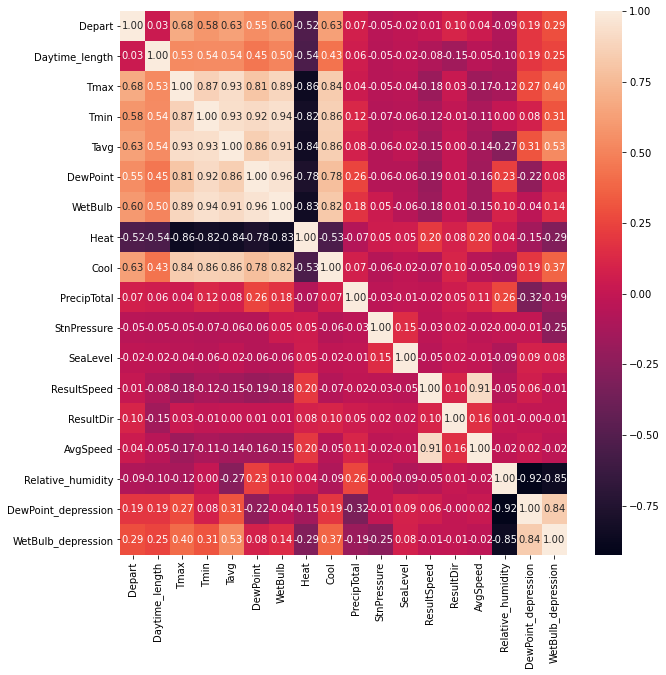

In [44]:
plt.subplots(figsize = (10, 10))
corr = df_w.corr(method = "pearson")
ax = sns.heatmap(corr, annot = True, annot_kws = {"size":10}, fmt = ".2f")
plt.show()

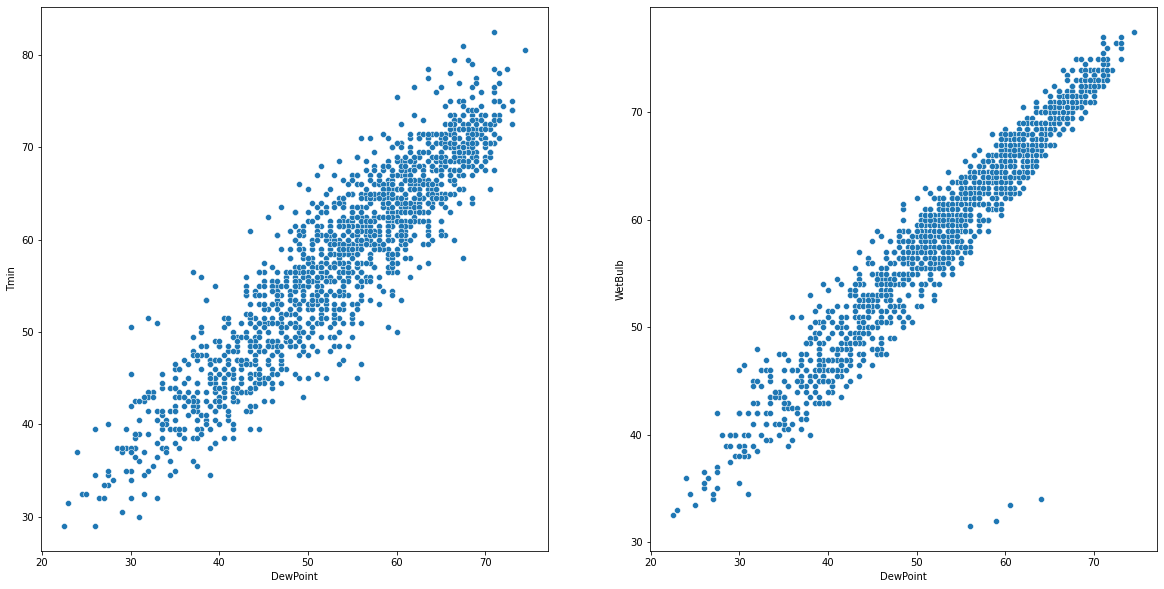

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
sns.scatterplot(x = "DewPoint", y = "Tmin", data = df_w, ax = ax[0])
sns.scatterplot(x = "DewPoint", y = "WetBulb", data = df_w, ax = ax[1])
plt.show()

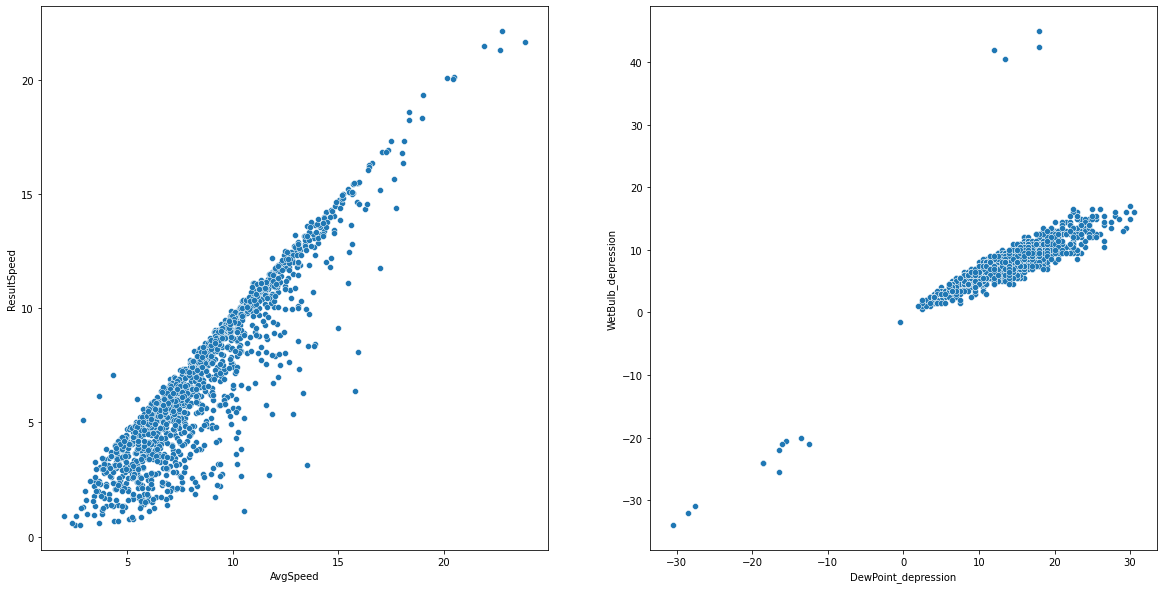

In [46]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
sns.scatterplot(x = "AvgSpeed", y = "ResultSpeed", data = df_w, ax = ax[0])
sns.scatterplot(x = "DewPoint_depression", y = "WetBulb_depression", data = df_w, ax= ax[1])
plt.show()

In [47]:
df_w["Date"] = pd.to_datetime(df_w["Date"])
df_w["dow"] = df_w["Date"].dt.dayofweek
df_w["dom"] = df_w["Date"].dt.day
df_w["month"] = df_w["Date"].dt.month
df_w["year"] = df_w["Date"].dt.year


In [48]:
#dfx['d'] = df_w["Date"].date().isocalendar()[1]
def set_week(x):
    pd.to_datetime(x)
    x = datetime.date(x).isocalendar()[1]
    return x

In [49]:
#dfs = df_w.copy()
df_w["week"] = df_w["Date"].apply(set_week)

In [50]:
def set_season(x):
    if 3 <= x <= 5 : season = "Spring"
    elif 6 <= x <= 8: season = "Summer"
    elif 9 <= x <= 11: season = "Fall"
    else: season = "Winter"
                    
    return(season)

def set_month(x):
    if x == 5: month = "May"
    elif x == 6: month = "June"
    elif x == 7: month = "July"
    elif x == 8: month = "Aug"
    elif x == 9: month = "Sep"   
    else: month = "Oct"
        
    return(month)

In [51]:
df_w["season"] = df_w.month.apply(set_season)
df_w["month"] = df_w["month"].apply(set_month)

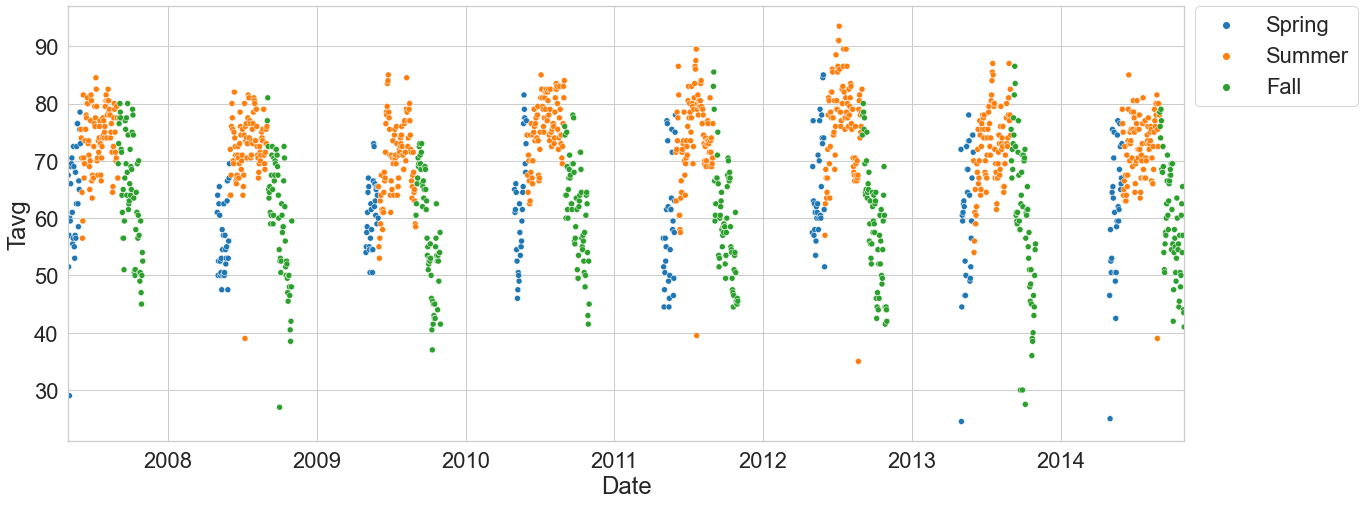

In [52]:
plt.figure(figsize = (20,8))
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 2)
ax = sns.scatterplot(x = "Date", y = "Tavg", hue = "season", data = df_w)
plt.legend(bbox_to_anchor = (1.01, 1), borderaxespad = 0)
ax.set_xlim(df_w["Date"].min(), df_w["Date"].max())
plt.show()

In [53]:
df_all = df_train.merge(df_w, on = "Date")
print(df_all.shape)
df_all.head()

(10506, 38)


Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   ...  AvgSpeed  Relative_humidity  DewPoint_depression WetBulb_depression  \
0  ...      6.95              55.63                 17.0               10.0   
1  ...      6.95              55.63                 17.0               10.0   
2  ...      6.95              55.63                 17.0               10.0   
3  ...      6.95              55.63                 17.0               10.0   
4  ...      6.95              55.63                 17.0               10.0   

  dow  dom  month  year  week  season  
0   1   29    May  2007    22  Spring  
1   1   29    May  2007    22  Spring  
2   1   29    May  2007    22  Spring  
3   1   29    May  2007    22  Spring  
4   1   29    May  2007    22  Spring  

[5 rows x 38 columns]

In [54]:
#seasons
year_c = df_all.year.value_counts()
year_wnv = df_all.groupby("year")["WnvPresent"].sum().sort_values(ascending = False)
year_c = year_c.to_frame().join(year_wnv.to_frame())
year_c = year_c.rename(columns = {
                    "year":"sample", "WnvPresent":"WnvSample"
})
#x = year_c["WnvSample"] * 100 / year_c["sample"]
year_c["WnvPerc"] = year_c["WnvSample"] * 100 / year_c["sample"]
year_c.reset_index(inplace = True)
year_c = year_c.rename(columns = {"index":"year"})
df_g_y = year_c.copy()
year_c

year  sample  WnvSample   WnvPerc
0  2007    3811        236  6.192600
1  2013    2392        239  9.991639
2  2009    2249         19  0.844820
3  2011    2054         57  2.775073

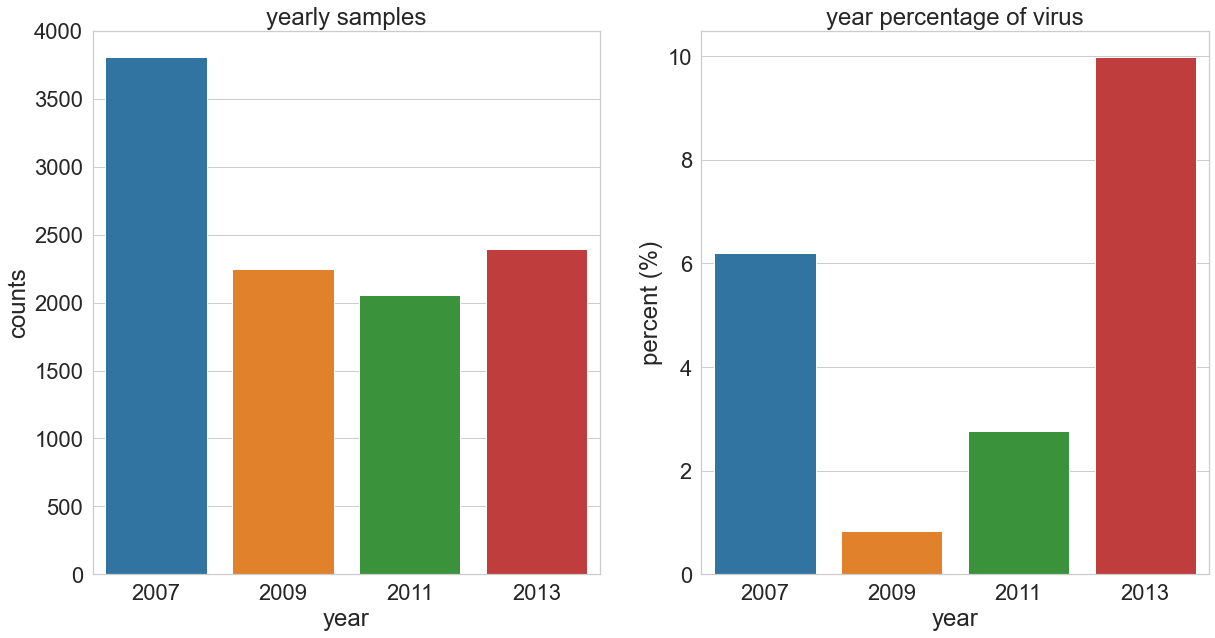

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))

graph1 = sns.barplot(x = "year", y = "sample", data = year_c, ax = ax[0])
graph1.set(ylabel = "counts")
graph1.set(title = "yearly samples")
graph2 = sns.barplot(x = "year", y = "WnvPerc", data = year_c, ax=ax[1])
graph2.set(ylabel = "percent (%)")
graph2.set(title = "year percentage of virus")
plt.show()

In [56]:
season_c = df_all.season.value_counts()
season_wnv = df_all.groupby("season")["WnvPresent"].sum().sort_values(ascending = False)
season_c = season_c.to_frame().join(season_wnv.to_frame())
season_c = season_c.rename(columns = {
    "season":"sample", 
    "WnvPresent":"WnvSample"
    })
season_c["WnvPerc"] = season_c["WnvSample"] * 100 / season_c["sample"]
season_c.reset_index(inplace = True)
season_c = season_c.rename(columns = {"index" : "season"})
season_c

season  sample  WnvSample   WnvPerc
0  Summer    7928        424  5.348133
1    Fall    2494        127  5.092221
2  Spring      84          0  0.000000

In [57]:
df_syc = df_all.groupby([(df_all.year), (df_all.season)])["season"].count()
df_syc_wnv = df_all.groupby([(df_all.year), (df_all.season)])["WnvPresent"].sum()
df_merge = pd.concat([df_syc, df_syc_wnv], axis = 1)
df_merge = df_merge.rename(columns = {
    "season":"sample",
    "WnvPresent":"WnvSample"
})

df_merge["WnvPerc"] = df_merge["WnvSample"] * 100 / df_merge["sample"]
df_merge.reset_index(inplace = True)
df_group_s = df_merge.copy()
df_merge

year  season  sample  WnvSample    WnvPerc
0  2007    Fall     985         30   3.045685
1  2007  Spring      25          0   0.000000
2  2007  Summer    2801        206   7.354516
3  2009    Fall     483          5   1.035197
4  2009  Spring      59          0   0.000000
5  2009  Summer    1707         14   0.820152
6  2011    Fall     540         22   4.074074
7  2011  Summer    1514         35   2.311757
8  2013    Fall     486         70  14.403292
9  2013  Summer    1906        169   8.866737

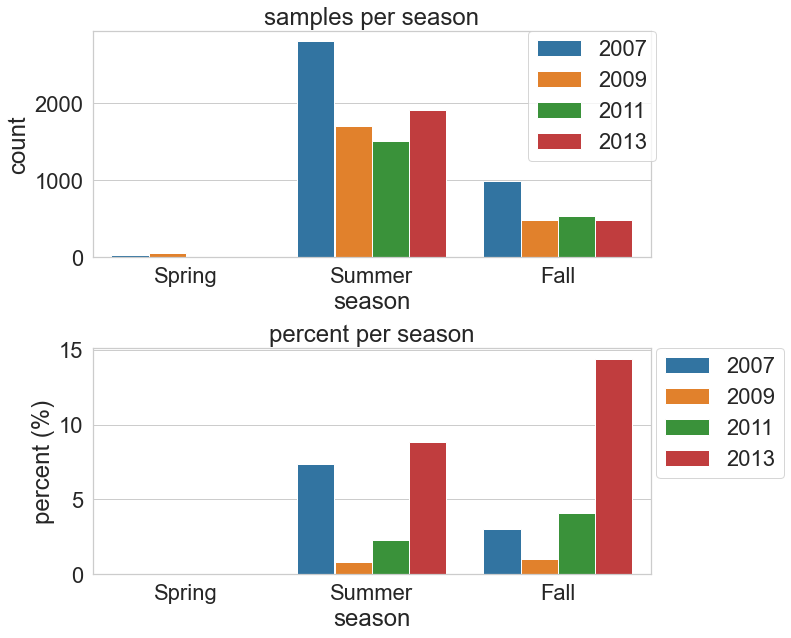

In [58]:
fig, ax = plt.subplots(2, 1, figsize = (10, 10))
month_order = ["Spring", "Summer", "Fall"]
graph1 = sns.barplot(x = "season", y = "sample", hue = "year", data = df_merge, order = month_order, ax = ax[0])
graph1.set(title = "samples per season")
graph1.set(ylabel = "count")
graph1.legend(bbox_to_anchor = (1.01, 1), borderaxespad = 0)

plt.subplots_adjust(hspace = .40)

graph2 = sns.barplot(x = "season", y = "WnvPerc", hue = "year", data = df_merge, order = month_order, ax = ax[1])
graph2.set(title = "percent per season")
graph2.set(ylabel = "percent (%)")
graph2.legend(bbox_to_anchor = (1.01, 1), borderaxespad = 0)

In [59]:
month_c = df_all.month.value_counts()
month_wnv = df_all.groupby("month")["WnvPresent"].sum().sort_values(ascending = False)
month_c = month_c.to_frame().join(month_wnv.to_frame())
month_c = month_c.rename(columns = {
    "month":"total_count",
    "WnvPresent":"Wnv_count"
})
#month_c
month_c["WnvPerc"] = month_c["Wnv_count"] * 100 / month_c["total_count"]
month_c.sort_values(by = "WnvPerc", ascending = False)

total_count  Wnv_count    WnvPerc
Aug          3751        377  10.050653
Sep          2218        125   5.635708
July         2606         46   1.765157
Oct           276          2   0.724638
June         1571          1   0.063654
May            84          0   0.000000

In [60]:
df_my = df_all.groupby([(df_all.year), (df_all.month)]).mean()[["Tavg", "PrecipTotal"]]
df_myc = df_all.groupby([(df_all.year),(df_all.month)])["month"].count()
df_myv = df_all.groupby([(df_all.year), (df_all.month)])["WnvPresent"].sum()
df_merge = pd.concat([df_myc, df_myv], axis = 1)
df_merge = df_merge.rename(columns = {
    "month":"sample",
    "WnvPresent":"WnvSample"
})
df_merge["WnvPerc"] = df_merge["WnvSample"] * 100 / df_merge["sample"]
df_mergeA = df_my.merge(df_merge, how = "outer", left_index = True, right_index = True)
df_mergeA.reset_index(inplace = True)
df_gmonthly = df_mergeA.copy()
df_mergeA = df_mergeA.sort_values(["year", "month"], ascending = (True, True))

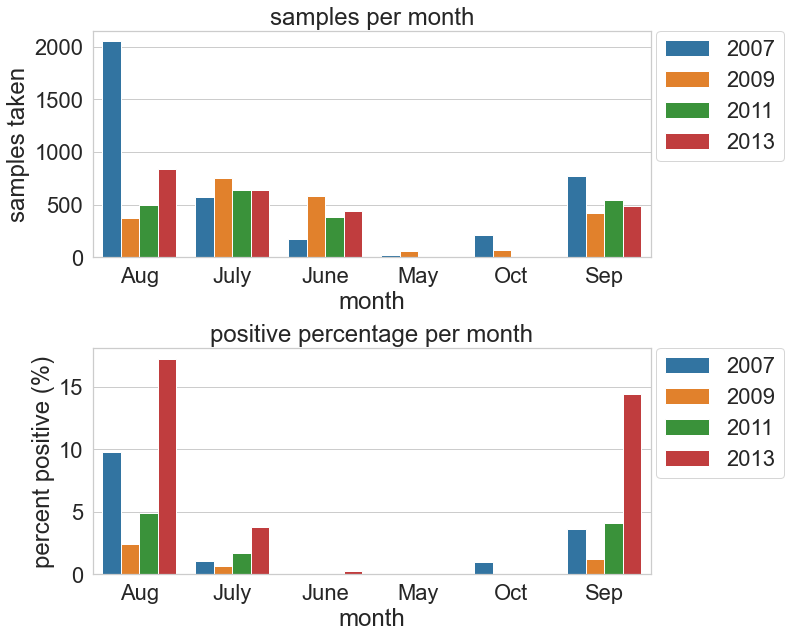

In [61]:
fig, ax = plt.subplots(2, 1, figsize = (10,10))
graph1 = sns.barplot(x = "month", y = "sample", hue = "year", data = df_mergeA, ax = ax[0])
graph1.set(title = "samples per month")
graph1.set(ylabel = "samples taken")
graph1.legend(bbox_to_anchor = (1.01, 1), borderaxespad = 0)

plt.subplots_adjust(hspace = .40)

graph2 = sns.barplot(x = "month", y = "WnvPerc", hue = "year", data = df_mergeA, ax = ax[1])
graph2.set(title = "positive percentage per month")
graph2.set(ylabel = "percent positive (%)")
graph2.legend(bbox_to_anchor = (1.01, 1), borderaxespad = 0)

In [62]:
week_c = df_all.week.value_counts()
week_wnv = df_all.groupby("week")["WnvPresent"].sum().sort_values(ascending = False)
week_c = week_c.to_frame().join(week_wnv.to_frame())
week_c = week_c.rename(columns = {
    "week":"sample",
    "WnvPresent":"WnvSample"
})
week_c["WnvPerc"] = week_c["WnvSample"] * 100 / week_c["sample"]
week_c.reset_index(inplace = True)
week_c = week_c.rename(columns = {"index":"week"})
week_c.set_index(["week"], inplace = True)
week_c.sort_values(by = "WnvPerc", ascending = False)

sample  WnvSample    WnvPerc
week                              
34       784        124  15.816327
36       431         53  12.296984
35       513         61  11.890838
33       804         86  10.696517
32       743         65   8.748318
37       532         37   6.954887
31      1241         51   4.109589
38       675         21   3.111111
30       738         20   2.710027
29       591         16   2.707276
39       468          7   1.495726
40       250          2   0.800000
28       981          7   0.713558
26       504          1   0.198413
25       332          0   0.000000
24       321          0   0.000000
23       383          0   0.000000
27       105          0   0.000000
22        84          0   0.000000
41        26          0   0.000000

In [63]:
df_wyc = df_all.groupby([(df_all.year), (df_all.month), (df_all.week)])["week"].count()
df_wycv = df_all.groupby([(df_all.year), (df_all.month), (df_all.week)])["WnvPresent"].sum()
df_merge = pd.concat([df_wyc, df_wycv], axis = 1)
df_merge = df_merge.rename(columns = {
    "week":"weekly_sample",
    "WnvPresent":"Wnv_count"
})
df_merge["WnvPerc"] = df_merge["Wnv_count"] * 100 / df_merge["weekly_sample"]
df_wy = df_all.groupby([(df_all.year), (df_all.month), (df_all.week)]).mean()

df_mergeB = df_wy.merge(df_merge, how= "outer", left_index = True, right_index = True)
df_mergeB.reset_index(inplace = True)
df_gweekly = df_mergeB.sort_values(["year", "week"], ascending = (True, True))
df_mergeB.head()

year month  week      Block   Latitude  Longitude  AddressAccuracy  \
0  2007   Aug    31  36.503608  41.798165 -87.662415         7.471861   
1  2007   Aug    32  32.990099  41.798999 -87.653208         7.089109   
2  2007   Aug    33  32.825059  41.790282 -87.653812         7.274232   
3  2007   Aug    34  37.626223  41.817106 -87.675442         7.667319   
4  2007   Aug    35  16.266667  41.692453 -87.575281         5.525000   

   NumMosquitos  WnvPresent    Depart  ...  ResultDir  AvgSpeed  \
0     14.438672    0.030303  7.992785  ...  13.621934  4.437230   
1     21.363036    0.066007  8.042904  ...  18.354785  7.973432   
2     26.314421    0.141844  2.134752  ...   8.482270  6.368085   
3     14.984344    0.176125  6.452055  ...  21.181996  7.239237   
4     39.566667    0.075000  9.000000  ...  20.500000  8.900000   

   Relative_humidity  DewPoint_depression  WetBulb_depression       dow  \
0          55.318456            17.545455           10.823954  2.212121   
1          73.858152             9.174917            6.567657  1.478548   
2          73.177092             9.319149            6.070922  2.475177   
3          75.886575             8.226027            6.090020  2.363992   
4          62.400000            14.000000            9.500000  1.000000   

         dom  weekly_sample  Wnv_count    WnvPerc  
0   1.212121            693         21   3.030303  
1   7.478548            303         20   6.600660  
2  15.475177            423         60  14.184397  
3  22.363992            511         90  17.612524  
4  28.000000            120          9   7.500000  

[5 rows x 32 columns]

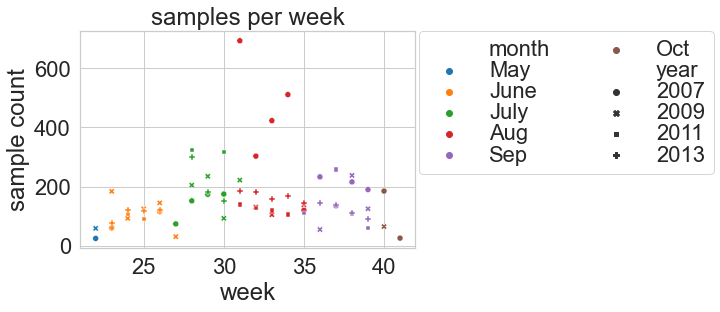

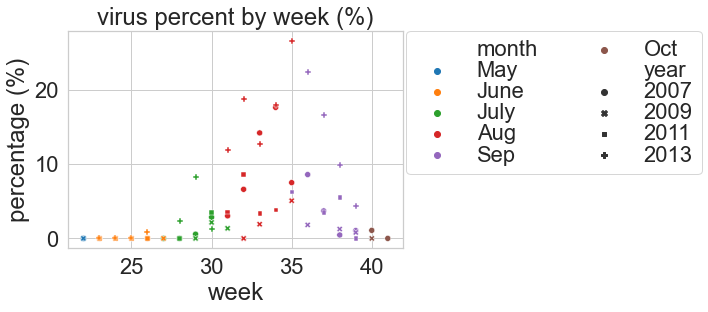

In [64]:
figsize = (30, 8)

graph1 = sns.scatterplot(x = "week", y = "weekly_sample", style = "year", hue = "month",
                        data = df_mergeB.sort_values(["year", "week"]))
graph1.set(title = "samples per week")
graph1.set(xlabel = "week")
graph1.set(ylabel = "sample count")
graph1.legend(bbox_to_anchor = (1.01, 1), ncol = 2, labelspacing = 0.05,
             borderaxespad = 0)
plt.show()

graph2 = sns.scatterplot(x = "week", y = "WnvPerc", style = "year", hue = "month",
                        data = df_mergeB.sort_values(["year", "week"]))
graph2.set(title = "virus percent by week (%)")
graph2.set(xlabel = "week")
graph2.set(ylabel = "percentage (%)")
graph2.legend(bbox_to_anchor = (1.01, 1), ncol = 2, labelspacing = 0.05,
             borderaxespad = 0)

In [65]:
df_d = df_all[["Date", "WnvPresent"]]
df_d.set_index(["Date"], inplace = True)
df_d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 1 columns):
WnvPresent    10506 non-null int64
dtypes: int64(1)
memory usage: 164.2 KB


In [66]:
y = df_d["WnvPresent"].resample("W").sum()
z = df_d["WnvPresent"].resample("W").count()
wk_perc = y.divide(z).multiply(100)
wk_perc.fillna(0, inplace = True)

Text(0, 0.5, 'percent (%)')

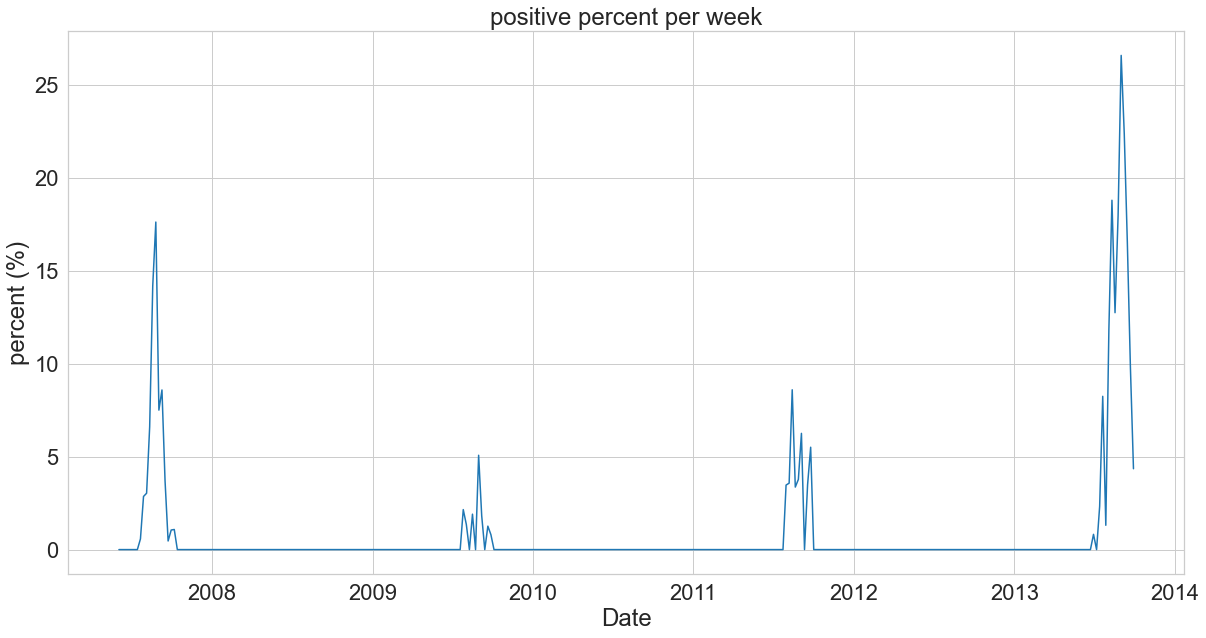

In [67]:
plt.figure(figsize = (20,10))
plt.plot(wk_perc)
plt.title("positive percent per week")
plt.xlabel("Date")
plt.ylabel("percent (%)")

In [68]:
y = df_d["WnvPresent"].resample("D").sum()
z = df_d["WnvPresent"].resample("D").count()
day_perc = y.divide(z).multiply(100)
day_perc.fillna(0, inplace = True)

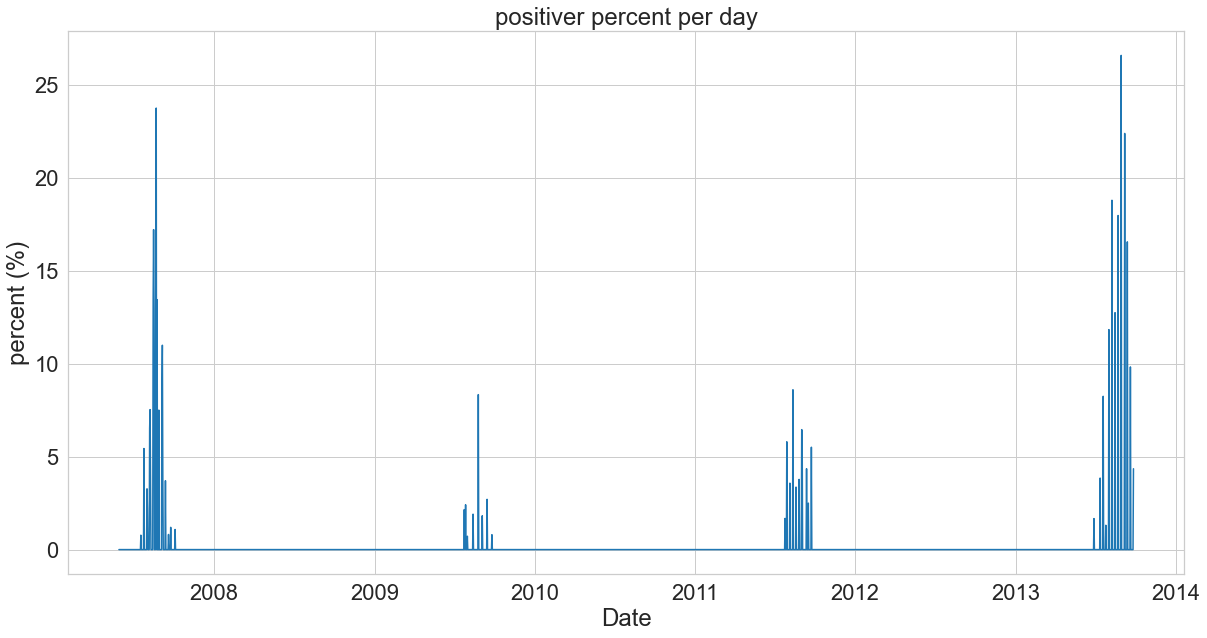

In [69]:
plt.figure(figsize = (20, 10))
plt.plot(day_perc)
plt.title("positiver percent per day")
plt.xlabel("Date")
plt.ylabel("percent (%)")
plt.show()

In [70]:
printmsg("Begin Machine Learning")

------------------------

 Begin Machine Learning

------------------------


In [71]:
#import ML modules
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import collections
import shap
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import traceback
import re
import string
import warnings

In [72]:
df_gyearly = df_g_y.copy()
df_gyearly.columns
df_all.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Depart', 'Sunrise', 'Sunset',
       'Daytime_length', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'Relative_humidity', 'DewPoint_depression',
       'WetBulb_depression', 'dow', 'dom', 'month', 'year', 'week', 'season'],
      dtype='object')

In [73]:

df_gyearly.rename(columns = {
    "WnvPerc":"WnvPercYearly"
}, inplace = True)
new_df = pd.merge(df_all, df_gyearly, how = 'left', left_on = ["year"],
                  right_on = ["year"])
df_gseason = df_group_s.copy()
df_gseason.rename(columns = {
    "WnvPerc":"WnvPercSeasonal"
}, inplace = True)
new_df1 = pd.merge(new_df, df_gseason, how = 'left', 
                  left_on = ["year", "season"], right_on = ["year", "season"])
df_gmonthly.rename(columns = {
    "WnvPerc":"WnvPercMonthly"
}, inplace = True)
new_df2 = pd.merge(new_df1, df_gmonthly, how = "left",
                  left_on = ["year", "month"], right_on = ["year", "month"])
df_gweekly.rename(columns = {
    "WnvPerc":"WnvPercWeekly"
}, inplace = True)
new_df3a = pd.merge(new_df2, df_gweekly, how = "left",
                   left_on = ["year", "week"], right_on = ["year", "week"])
new_df3 = new_df3a.copy()

In [74]:
new_df3.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block_x           Street  Trap  \
0  CULEX PIPIENS/RESTUANS       41   N OAK PARK AVE  T002   
1          CULEX RESTUANS       41   N OAK PARK AVE  T002   
2          CULEX RESTUANS       62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS       79     W FOSTER AVE  T015   
4          CULEX RESTUANS       79     W FOSTER AVE  T015   

              AddressNumberAndStreet  Latitude_x  Longitude_x  \
0  4100  N OAK PARK AVE, Chicago, IL   41.954690   -87.800991   
1  4100  N OAK PARK AVE, Chicago, IL   41.954690   -87.800991   
2   6200  N MANDELL AVE, Chicago, IL   41.994991   -87.769279   
3    7900  W FOSTER AVE, Chicago, IL   41.974089   -87.824812   
4    7900  W FOSTER AVE, Chicago, IL   41.974089   -87.824812   

   AddressAccuracy_x  ...  ResultDir_y  AvgSpeed_y  Relative_humidity_y  \
0                  9  ...         17.0        6.95                55.63   
1                  9  ...         17.0        6.95                55.63   
2                  9  ...         17.0        6.95                55.63   
3                  8  ...         17.0        6.95                55.63   
4                  8  ...         17.0        6.95                55.63   

  DewPoint_depression_y WetBulb_depression_y  dow_y  dom_y  weekly_sample  \
0                  17.0                 10.0    1.0   29.0             25   
1                  17.0                 10.0    1.0   29.0             25   
2                  17.0                 10.0    1.0   29.0             25   
3                  17.0                 10.0    1.0   29.0             25   
4                  17.0                 10.0    1.0   29.0             25   

   Wnv_count  WnvPercWeekly  
0          0            0.0  
1          0            0.0  
2          0            0.0  
3          0            0.0  
4          0            0.0  

[5 rows x 79 columns]

In [75]:
new_df3.columns

Index(['Date', 'Address', 'Species', 'Block_x', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude_x', 'Longitude_x',
       'AddressAccuracy_x', 'NumMosquitos_x', 'WnvPresent_x', 'Depart_x',
       'Sunrise', 'Sunset', 'Daytime_length_x', 'Tmax_x', 'Tmin_x', 'Tavg_x',
       'DewPoint_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'PrecipTotal_x',
       'StnPressure_x', 'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x',
       'AvgSpeed_x', 'Relative_humidity_x', 'DewPoint_depression_x',
       'WetBulb_depression_x', 'dow_x', 'dom_x', 'month_x', 'year', 'week',
       'season', 'sample_x', 'WnvSample_x', 'WnvPercYearly', 'sample_y',
       'WnvSample_y', 'WnvPercSeasonal', 'Tavg_y', 'PrecipTotal_y', 'sample',
       'WnvSample', 'WnvPercMonthly', 'month_y', 'Block_y', 'Latitude_y',
       'Longitude_y', 'AddressAccuracy_y', 'NumMosquitos_y', 'WnvPresent_y',
       'Depart_y', 'Daytime_length_y', 'Tmax_y', 'Tmin_y', 'Tavg',
       'DewPoint_y', 'WetBulb_y', 'Heat_y', 'Cool_y', 'PrecipTota

In [76]:
new_df3.drop(columns = ['sample_y',
       'WnvSample_y', 'Tavg_y', 'PrecipTotal_y', 'month_y', 'Block_y', 'Latitude_y',
       'Longitude_y', 'AddressAccuracy_y', 'NumMosquitos_y', 'WnvPresent_y',
       'Depart_y', 'Daytime_length_y', 'Tmax_y', 'Tmin_y', 
                       'DewPoint_y', 'WetBulb_y', 'Heat_y', 'Cool_y',
                      'StnPressure_y', 'SeaLevel_y', 'ResultSpeed_y', 'ResultDir_y',
       'AvgSpeed_y', 'Relative_humidity_y', 'DewPoint_depression_y',
       'WetBulb_depression_y', 'dow_y', 'dom_y'], inplace = True)

In [77]:
new_df3.columns

Index(['Date', 'Address', 'Species', 'Block_x', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude_x', 'Longitude_x',
       'AddressAccuracy_x', 'NumMosquitos_x', 'WnvPresent_x', 'Depart_x',
       'Sunrise', 'Sunset', 'Daytime_length_x', 'Tmax_x', 'Tmin_x', 'Tavg_x',
       'DewPoint_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'PrecipTotal_x',
       'StnPressure_x', 'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x',
       'AvgSpeed_x', 'Relative_humidity_x', 'DewPoint_depression_x',
       'WetBulb_depression_x', 'dow_x', 'dom_x', 'month_x', 'year', 'week',
       'season', 'sample_x', 'WnvSample_x', 'WnvPercYearly', 'WnvPercSeasonal',
       'sample', 'WnvSample', 'WnvPercMonthly', 'Tavg', 'PrecipTotal',
       'weekly_sample', 'Wnv_count', 'WnvPercWeekly'],
      dtype='object')

In [78]:
features = [x for x in new_df3.columns if x not in ['Block_x','dow_x',
            'dom_x', 'week', 'month', 'year', 'season',
       'WnvPresent_x','Wnv_count','WnvPerc']]

In [79]:
def scatterplots(columns, ncol=None,figsize=(15,15)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, y = 'Wnv_percent', data=df_mergeB, alpha=0.5)
        ax.set(xlabel=col, ylabel='Wnv(%)')
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.xaxis.label.set_size(12)
        ax.yaxis.label.set_size(12)
        
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [80]:
#scatterplots(features, ncol = 4)


In [81]:
df = new_df3.copy()

df.columns

Index(['Date', 'Address', 'Species', 'Block_x', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude_x', 'Longitude_x',
       'AddressAccuracy_x', 'NumMosquitos_x', 'WnvPresent_x', 'Depart_x',
       'Sunrise', 'Sunset', 'Daytime_length_x', 'Tmax_x', 'Tmin_x', 'Tavg_x',
       'DewPoint_x', 'WetBulb_x', 'Heat_x', 'Cool_x', 'PrecipTotal_x',
       'StnPressure_x', 'SeaLevel_x', 'ResultSpeed_x', 'ResultDir_x',
       'AvgSpeed_x', 'Relative_humidity_x', 'DewPoint_depression_x',
       'WetBulb_depression_x', 'dow_x', 'dom_x', 'month_x', 'year', 'week',
       'season', 'sample_x', 'WnvSample_x', 'WnvPercYearly', 'WnvPercSeasonal',
       'sample', 'WnvSample', 'WnvPercMonthly', 'Tavg', 'PrecipTotal',
       'weekly_sample', 'Wnv_count', 'WnvPercWeekly'],
      dtype='object')

In [82]:
df.rename(columns = {
    "Block_x":"Block",
    "Latitude_x":"Lat",
    "Longitude_x":"Long",
    "NumMosquitos_x":"NumMosquitos",
    "WnvPresent_x":"WnvPresent",
    "Daytime_length_x":"Daytime_length",
    "Tmax_x":"Tmax", "Tmin_x":"Tmin",
    "Heat_x":"Heat", "Cool_x":"Cool", "PrecipTotal_x":"PrecipTotal",
    "SeaLevel_x":"SeaLevel", "ResultSpeed_x":"ResultSpeed",
    "ResultDir_x":"ResultDir", "AvgSpeed_x":"AvgSpeed",
    "Relative_humidity_x":"Relative_humidity",
    "dow_x":"dow", "dom_x":"dom", "month_x":"month", 
    "WnvSample_x":"WnvSample",
    "AddressAccuracy_x":"AddressAccuracy"
}, inplace = True)

df.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Lat', 'Long', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'Depart_x', 'Sunrise', 'Sunset',
       'Daytime_length', 'Tmax', 'Tmin', 'Tavg_x', 'DewPoint_x', 'WetBulb_x',
       'Heat', 'Cool', 'PrecipTotal', 'StnPressure_x', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Relative_humidity',
       'DewPoint_depression_x', 'WetBulb_depression_x', 'dow', 'dom', 'month',
       'year', 'week', 'season', 'sample_x', 'WnvSample', 'WnvPercYearly',
       'WnvPercSeasonal', 'sample', 'WnvSample', 'WnvPercMonthly', 'Tavg',
       'PrecipTotal', 'weekly_sample', 'Wnv_count', 'WnvPercWeekly'],
      dtype='object')

In [83]:
df.drop(columns = {
    "Depart_x", "Tavg_x", "DewPoint_x", "WetBulb_x",
    "DewPoint_depression_x", "WetBulb_depression_x", "sample_x",
    "Tavg_x"
}, inplace = True)
df.drop(columns = {
    "Tmax", "Tmin", "StnPressure_x", "AvgSpeed"
}, inplace = True)
df.drop(columns = {
    "Date", "Address", "Street", "Trap", "Sunrise", "Sunset", 
    "AddressNumberAndStreet"
}, inplace = True)

df.columns

Index(['Species', 'Block', 'Lat', 'Long', 'AddressAccuracy', 'NumMosquitos',
       'WnvPresent', 'Daytime_length', 'Heat', 'Cool', 'PrecipTotal',
       'SeaLevel', 'ResultSpeed', 'ResultDir', 'Relative_humidity', 'dow',
       'dom', 'month', 'year', 'week', 'season', 'WnvSample', 'WnvPercYearly',
       'WnvPercSeasonal', 'sample', 'WnvSample', 'WnvPercMonthly', 'Tavg',
       'PrecipTotal', 'weekly_sample', 'Wnv_count', 'WnvPercWeekly'],
      dtype='object')

In [84]:
from sklearn.preprocessing import OneHotEncoder
df_encoded = pd.get_dummies(df, columns = ["Species", 
                                          "season", "month"])

In [85]:
df_encoded.columns

Index(['Block', 'Lat', 'Long', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent',
       'Daytime_length', 'Heat', 'Cool', 'PrecipTotal', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'Relative_humidity', 'dow', 'dom', 'year',
       'week', 'WnvSample', 'WnvPercYearly', 'WnvPercSeasonal', 'sample',
       'WnvSample', 'WnvPercMonthly', 'Tavg', 'PrecipTotal', 'weekly_sample',
       'Wnv_count', 'WnvPercWeekly', 'Species_CULEX ERRATICUS',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'Species_CULEX SALINARIUS',
       'Species_CULEX TARSALIS', 'Species_CULEX TERRITANS', 'season_Fall',
       'season_Spring', 'season_Summer', 'month_Aug', 'month_July',
       'month_June', 'month_May', 'month_Oct', 'month_Sep'],
      dtype='object')

In [86]:
df_encoded.drop(columns = {
    'Species_CULEX TERRITANS', 'Species_CULEX SALINARIUS', 
    'Species_CULEX TARSALIS', 'Species_CULEX ERRATICUS',
    "month_May"
}, inplace = True)

In [87]:
df_encoded.columns
dftest = df_encoded.copy()
dftest.columns
dftest.drop(dftest.columns[9], axis=1, inplace = True)
dftest.columns
df_encoded.columns
df_encoded.drop(df_encoded.columns[9], axis=1, inplace = True)
#df_encoded.drop(df_encoded.columns[21], axis=1, inplace = True)
df_encoded.columns

Index(['Block', 'Lat', 'Long', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent',
       'Daytime_length', 'Heat', 'Cool', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'Relative_humidity', 'dow', 'dom', 'year', 'week',
       'WnvSample', 'WnvPercYearly', 'WnvPercSeasonal', 'sample', 'WnvSample',
       'WnvPercMonthly', 'Tavg', 'weekly_sample', 'Wnv_count', 'WnvPercWeekly',
       'Species_CULEX PIPIENS', 'Species_CULEX PIPIENS/RESTUANS',
       'Species_CULEX RESTUANS', 'season_Fall', 'season_Spring',
       'season_Summer', 'month_Aug', 'month_July', 'month_June', 'month_Oct',
       'month_Sep'],
      dtype='object')

In [88]:
dftest.columns
#dftest.drop(dftest.columns[22], axis=1, inplace = True)

dftest.drop(dftest.columns[21], axis=1, inplace = True)
#x = dftest.columns.get_loc("WnvSample")

#print(x)

dftest.columns

Index(['Block', 'Lat', 'Long', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent',
       'Daytime_length', 'Heat', 'Cool', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'Relative_humidity', 'dow', 'dom', 'year', 'week',
       'WnvPercYearly', 'WnvPercSeasonal', 'sample', 'WnvPercMonthly', 'Tavg',
       'weekly_sample', 'Wnv_count', 'WnvPercWeekly', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'season_Fall', 'season_Spring', 'season_Summer', 'month_Aug',
       'month_July', 'month_June', 'month_Oct', 'month_Sep'],
      dtype='object')

In [89]:
dftest = dftest.loc[:,~dftest.columns.duplicated()]
dftest.columns

Index(['Block', 'Lat', 'Long', 'AddressAccuracy', 'NumMosquitos', 'WnvPresent',
       'Daytime_length', 'Heat', 'Cool', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'Relative_humidity', 'dow', 'dom', 'year', 'week',
       'WnvPercYearly', 'WnvPercSeasonal', 'sample', 'WnvPercMonthly', 'Tavg',
       'weekly_sample', 'Wnv_count', 'WnvPercWeekly', 'Species_CULEX PIPIENS',
       'Species_CULEX PIPIENS/RESTUANS', 'Species_CULEX RESTUANS',
       'season_Fall', 'season_Spring', 'season_Summer', 'month_Aug',
       'month_July', 'month_June', 'month_Oct', 'month_Sep'],
      dtype='object')

In [90]:
df_encoded = df_encoded.loc[:,~df_encoded.columns.duplicated()]

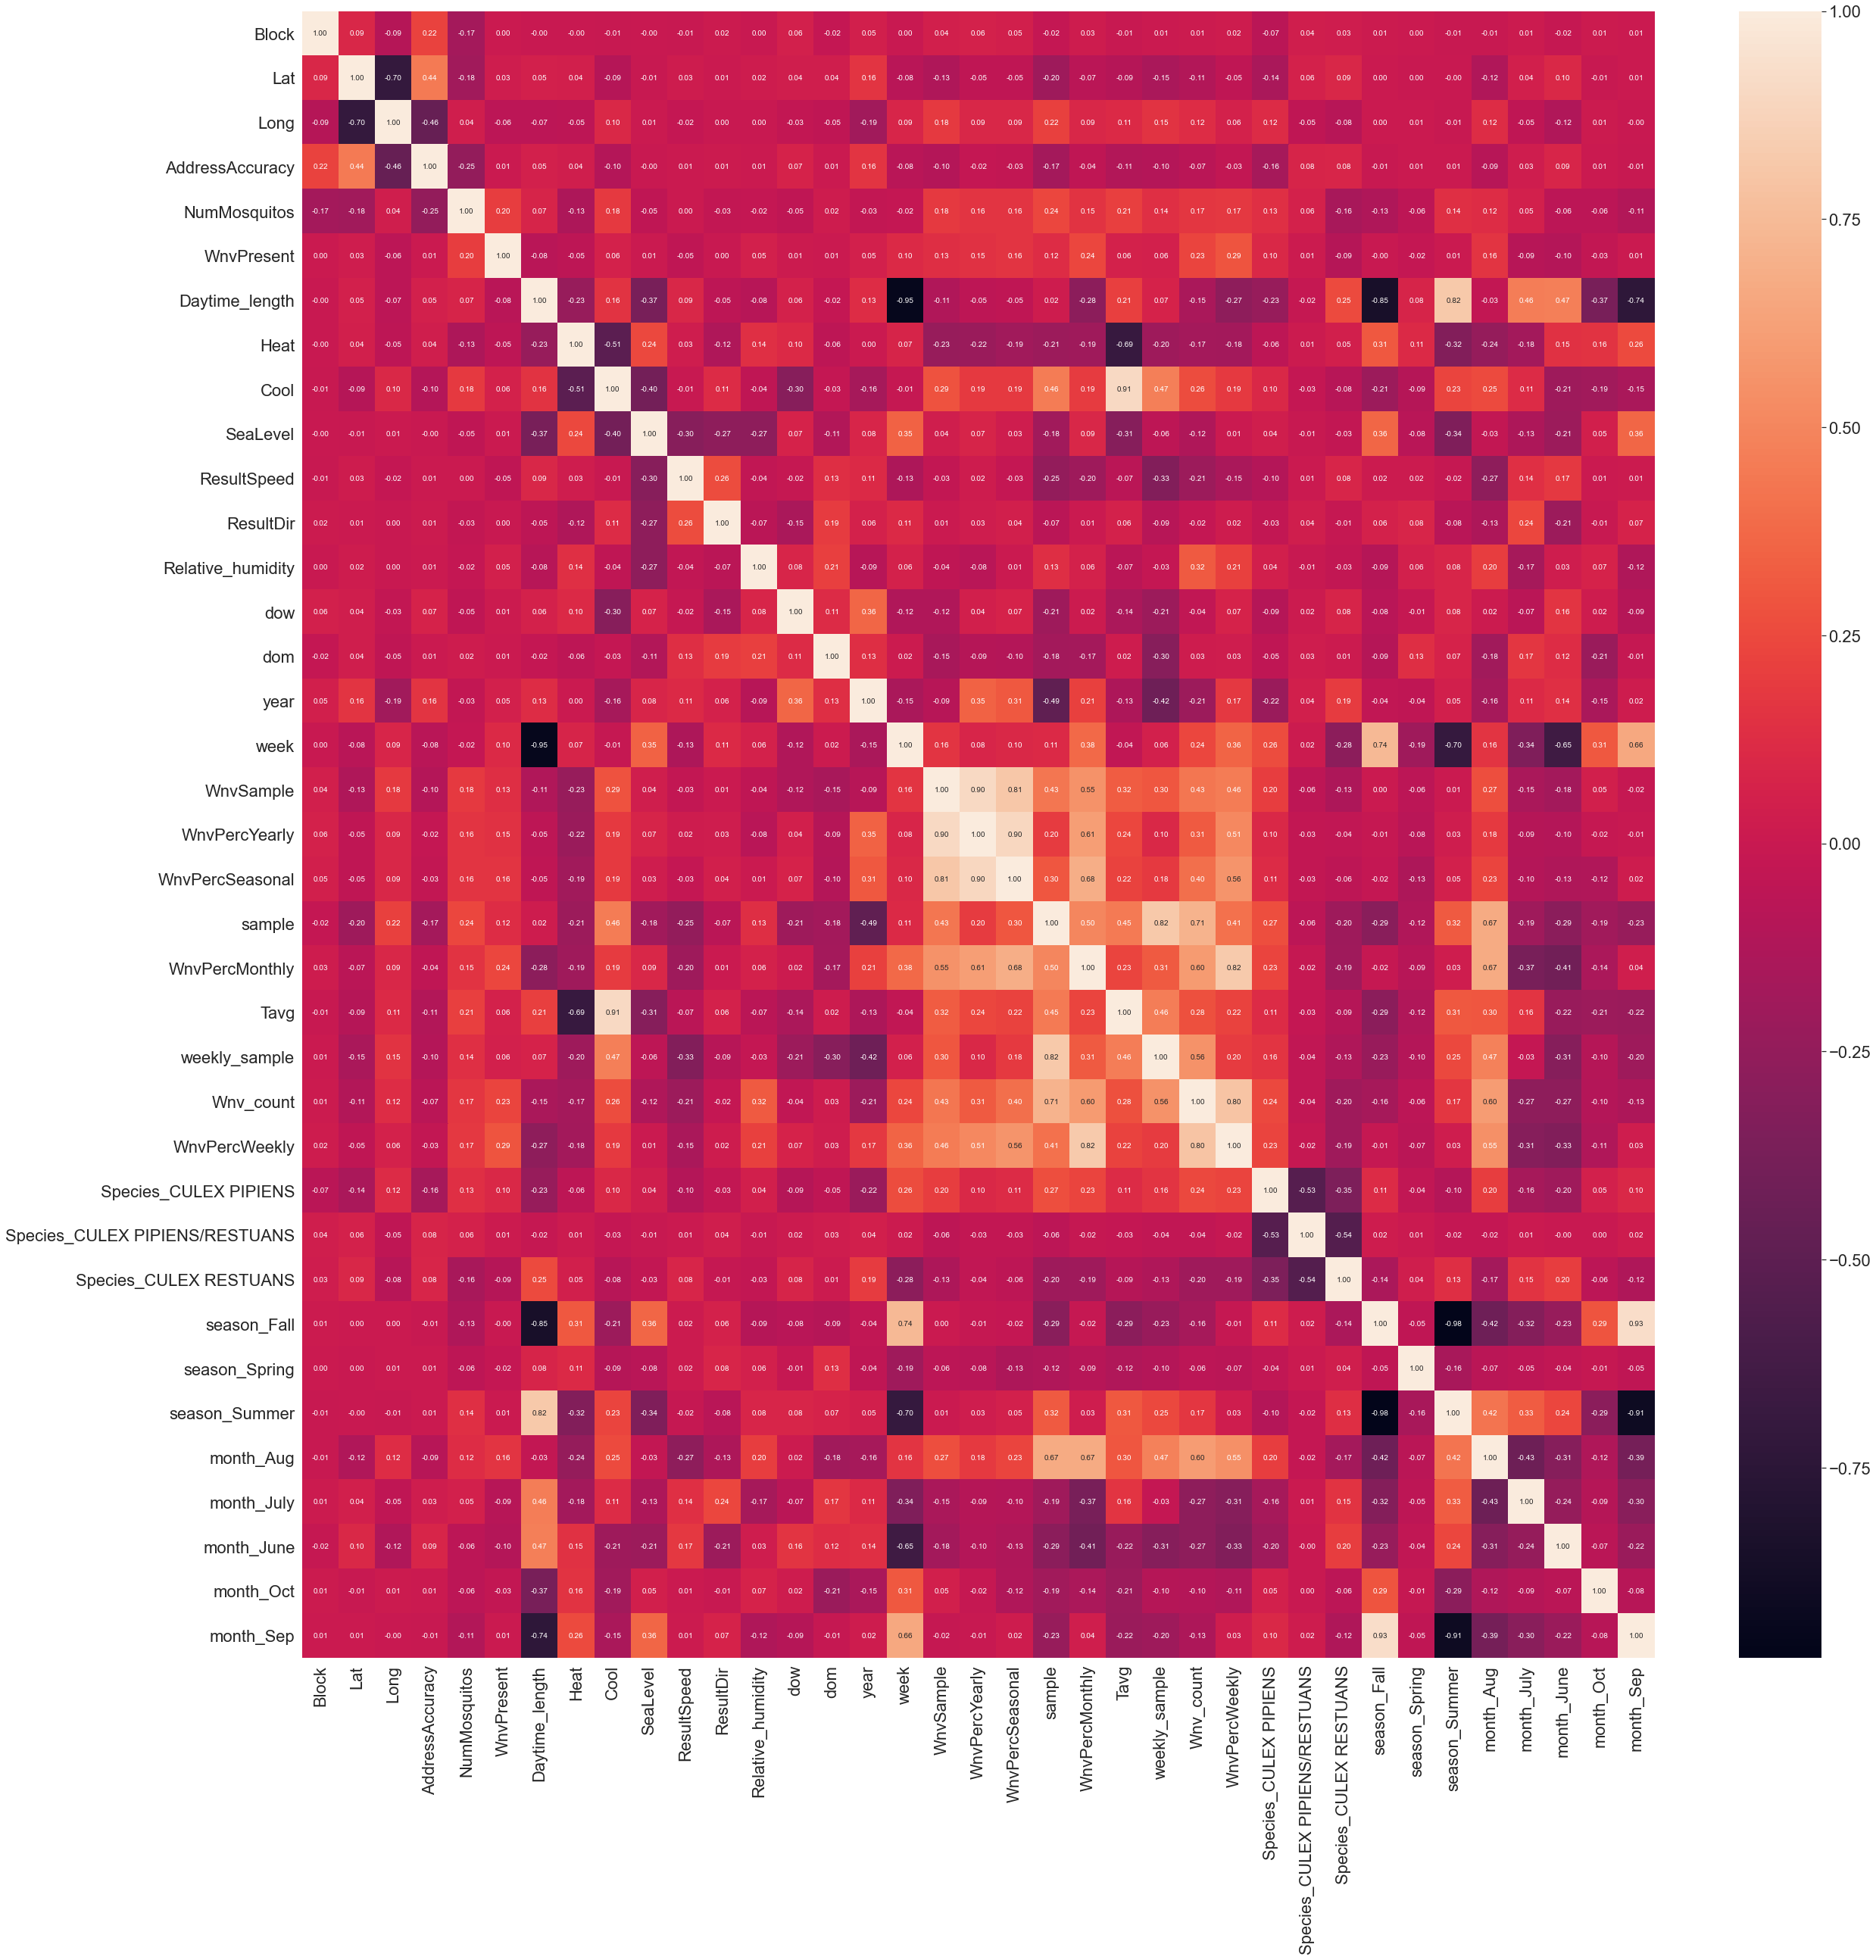

In [91]:
plt.subplots(figsize = (40,40))

corr = df_encoded.corr(method = "pearson")
ax = sns.heatmap(corr, annot = True, annot_kws = {"size":10}, fmt = ".2f")

In [92]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate,GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
#from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

from sklearn.ensemble import RandomForestClassifier

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns = "WnvPresent"),
                                                   df_encoded.WnvPresent, test_size = 0.3,
                                                   random_state = 47)

In [94]:
clf = RandomForestClassifier(n_estimators = 300, random_state = 1, n_jobs = -1)
model_res = clf.fit(X_train, y_train)
print(model_res)

y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)

lr_probs = y_pred_prob[:, 1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average = "weighted")
cm = confusion_matrix(y_test, y_pred)

print("Random Forest Accuracy: %.3f" % (ac))
print("Random Forest F1-score: %.3f" % (f1))



RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=1)
Random Forest Accuracy: 0.947
Random Forest F1-score: 0.934


In [95]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [96]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns = "WnvPresent"),
                                                   df_encoded.WnvPresent, test_size = 0.3,
                                                   random_state = 47)


In [97]:
max_bin = 20
force_bin = 3

#binning func
def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    #print("justmiss", justmiss)
    #print("notmiss", notmiss)
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            #print("I am here 1",r, n,len(d2))
            n = n - 1 
            
        except Exception as e:
            n = n - 1
            #print("I am here e",n)

    if len(d2) == 1:
        #print("I am second step ",r, n)
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        #print(justmiss.count().Y)
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    print(np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT))
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    #print("hi",d3.IV )
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    for i in x:
        print(i)
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                #print("Number and unique value greater than 2")
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                #print("I am here 2")
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [98]:
pd.set_option('display.max_columns', None)
X_train.head()

Block        Lat       Long  AddressAccuracy  NumMosquitos  \
4381     61  41.991429 -87.747113                8             3   
8001     77  41.754676 -87.612922                9             1   
8465     22  41.801179 -87.679447                8             4   
8840     58  41.987280 -87.666066                8            50   
1062     30  41.836644 -87.677737                8             5   

      Daytime_length  Heat  Cool   SeaLevel  ResultSpeed  ResultDir  \
4381           15.22   0.0  13.5  29.840000         6.40        4.0   
8001           12.13  10.0   0.0  30.055000         5.00       36.0   
8465           15.22   0.0  13.0  29.719999         6.65       29.0   
8840           15.02   0.0   6.0  30.095001         4.05        8.0   
1062           14.43   0.0  15.5  29.990000         2.80       11.0   

      Relative_humidity  dow  dom  year  week  WnvSample  WnvPercYearly  \
4381              54.10    4   26  2009    26         19       0.844820   
8001              68.95    4   23  2011    38         57       2.775073   
8465              66.69    3   27  2013    26        239       9.991639   
8840              53.99    4   12  2013    28        239       9.991639   
1062              54.38    2    1  2007    31        236       6.192600   

      WnvPercSeasonal  sample  WnvPercMonthly       Tavg  weekly_sample  \
4381         0.820152     578        0.000000  78.858621            145   
8001         4.074074     540        4.074074  55.000000            109   
8465         8.866737     436        0.229358  76.770492            122   
8840         8.866737     636        3.773585  73.965116            301   
1062         7.354516    2050        9.756098  80.697691            693   

      Wnv_count  WnvPercWeekly  Species_CULEX PIPIENS  \
4381          0       0.000000                      0   
8001          6       5.504587                      0   
8465          1       0.819672                      0   
8840          7       2.325581                      0   
1062         21       3.030303                      1   

      Species_CULEX PIPIENS/RESTUANS  Species_CULEX RESTUANS  season_Fall  \
4381                               0                       1            0   
8001                               0                       1            1   
8465                               0                       1            0   
8840                               1                       0            0   
1062                               0                       0            0   

      season_Spring  season_Summer  month_Aug  month_July  month_June  \
4381              0              1          0           0           1   
8001              0              0          0           0           0   
8465              0              1          0           0           1   
8840              0              1          0           1           0   
1062              0              1          1           0           0   

      month_Oct  month_Sep  
4381          0          0  
8001          0          1  
8465          0          0  
8840          0          0  
1062          0          0

In [99]:
X_train.WnvSample

4381      19
8001      57
8465     239
8840     239
1062     236
9013     239
8231     239
10393    239
2975     236
2876     236
96       236
7878      57
5959      19
1165     236
4292      19
3827      19
6875      57
1672     236
9956     239
3306     236
8647     239
9718     239
10404    239
2610     236
9408     239
5995      19
1284     236
2887     236
6193      57
7189      57
        ... 
1615     236
6073      57
5257      19
9317     239
9140     239
3281     236
4319      19
4846      19
5056      19
2850     236
9948     239
7733      57
9961     239
6825      57
1608     236
7092      57
4475      19
6209      57
562      236
3185     236
2733     236
10311    239
8967     239
7227      57
3095     236
2896     236
8883     239
6728      57
1926     236
5255      19
Name: WnvSample, Length: 7354, dtype: int64

In [100]:
final_iv, IV = data_vars(X_train, y_train)

Block
0   -0.037259
1    0.036544
dtype: float64
Lat
0   -0.133451
1    0.121575
dtype: float64
Long
0    0.197940
1   -0.241712
dtype: float64
AddressAccuracy
0    0.002923
1   -0.004730
dtype: float64
NumMosquitos
0   -1.934151
1   -0.935854
2    0.164444
3    0.980866
dtype: float64
Daytime_length
0    0.565881
1    0.136170
2   -2.246854
dtype: float64
Heat
0    0.097550
1   -1.370027
dtype: float64
Cool
0   -0.092446
1    0.088111
dtype: float64
SeaLevel
0    0.001051
1   -0.001206
dtype: float64
ResultSpeed
0    0.160421
1    0.044622
2   -0.252848
dtype: float64
ResultDir
0   -0.045285
1    0.049206
dtype: float64
Relative_humidity
0   -0.208012
1   -0.071127
2    0.241500
dtype: float64
dow
0    0.164329
1   -0.369463
dtype: float64
dom
0   -0.084008
1   -0.016416
2    0.102381
dtype: float64
year
0   -0.225676
1    0.243313
dtype: float64
week
0   -1.227932
1    0.575564
dtype: float64
WnvSample
0   -1.028629
1    0.170003
2    0.658623
dtype: float64
WnvPercYearly
0   -1.0286

In [101]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train[features]
display(X2.shape)
X2.head()

(7354, 21)

Heat        Lat       Long  Relative_humidity  ResultSpeed  \
4381   0.0  41.991429 -87.747113              54.10         6.40   
8001  10.0  41.754676 -87.612922              68.95         5.00   
8465   0.0  41.801179 -87.679447              66.69         6.65   
8840   0.0  41.987280 -87.666066              53.99         4.05   
1062   0.0  41.836644 -87.677737              54.38         2.80   

      Species_CULEX PIPIENS  Species_CULEX RESTUANS       Tavg  \
4381                      0                       1  78.858621   
8001                      0                       1  55.000000   
8465                      0                       1  76.770492   
8840                      0                       0  73.965116   
1062                      1                       0  80.697691   

      WnvPercSeasonal  WnvPercYearly  WnvSample  dow  month_Aug  month_July  \
4381         0.820152       0.844820         19    4          0           0   
8001         4.074074       2.775073         57    4          0           0   
8465         8.866737       9.991639        239    3          0           0   
8840         8.866737       9.991639        239    4          0           1   
1062         7.354516       6.192600        236    2          1           0   

      month_June  month_Oct  month_Sep  sample  week  weekly_sample  year  
4381           1          0          0     578    26            145  2009  
8001           0          0          1     540    38            109  2011  
8465           1          0          0     436    26            122  2013  
8840           0          0          0     636    28            301  2013  
1062           0          0          0    2050    31            693  2007

In [102]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

X1 = X2._get_numeric_data()
final_df, final_vif = iterate_vif(X1)

Iteration # 1
Removing Long with VIF of 1647870.018921
Iteration # 2
Removing year with VIF of 146586.323022
Iteration # 3
Removing week with VIF of 883.957045
Iteration # 4
Removing Lat with VIF of 432.393200
Iteration # 5
Removing Tavg with VIF of 142.085853
Iteration # 6
Removing WnvPercYearly with VIF of 61.993784
Iteration # 7
Removing Relative_humidity with VIF of 40.501037
Iteration # 8
Removing sample with VIF of 16.924946
Iteration # 9
Removing WnvSample with VIF of 13.163723
Iteration # 10
Removing month_Aug with VIF of 8.459789
Iteration # 11
Complete


In [103]:
X_train=final_df
display(len(X_train.columns))
display(X_train.columns)
X_train.head()

11

Index(['Heat', 'ResultSpeed', 'Species_CULEX PIPIENS',
       'Species_CULEX RESTUANS', 'WnvPercSeasonal', 'dow', 'month_July',
       'month_June', 'month_Oct', 'month_Sep', 'weekly_sample'],
      dtype='object')

Heat  ResultSpeed  Species_CULEX PIPIENS  Species_CULEX RESTUANS  \
4381   0.0         6.40                      0                       1   
8001  10.0         5.00                      0                       1   
8465   0.0         6.65                      0                       1   
8840   0.0         4.05                      0                       0   
1062   0.0         2.80                      1                       0   

      WnvPercSeasonal  dow  month_July  month_June  month_Oct  month_Sep  \
4381         0.820152    4           0           1          0          0   
8001         4.074074    4           0           0          0          1   
8465         8.866737    3           0           1          0          0   
8840         8.866737    4           1           0          0          0   
1062         7.354516    2           0           0          0          0   

      weekly_sample  
4381            145  
8001            109  
8465            122  
8840            301  
1062            693

In [104]:
printmsg("Begin Modeling")


------------------------

 Begin Modeling

------------------------


In [105]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop(columns = "WnvPresent"),
                                                   df_encoded.WnvPresent, test_size = 0.3,
                                                   random_state = 47)

In [106]:
X_train.shape

(7354, 36)

In [107]:
X_test.shape

(3152, 36)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
Features [6.98441020e-02 8.04305481e-02 9.09252721e-02 2.34129842e-02
 1.62628848e-01 3.94927926e-02 2.18023396e-03 1.42908644e-02
 1.29169593e-02 1.80817656e-02 1.32200833e-02 1.35753828e-02
 8.12048173e-03 1.23146131e-02 4.46325630e-03 3.56596499e-02
 3.76101130e-03 1.15669382e-02 1.71817681e-02 5.53477936e-03
 7.61594542e-02 6.39408865e-03 1.09375480e-02 1.06980105e-01
 8.58923198e-02 1.57807752e-02 1.66356436e-02 1.24788609e-02
 3.07687293e-03 0.00000000e+00 1.97141946e-03 2.03382745e-03
 6.93486158e-03 1.33387232e-02 3.32062000e-05 1.74995904e-03]


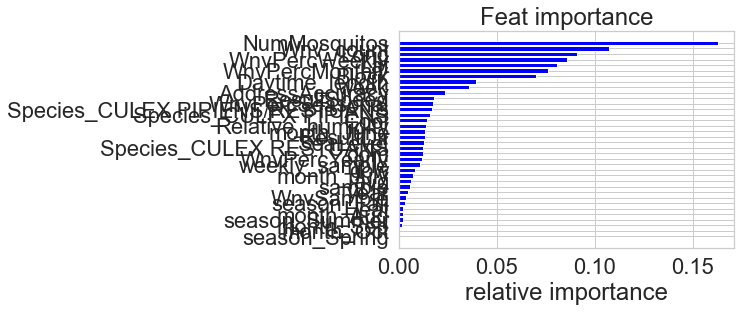

[[2901   91]
 [ 123   37]]


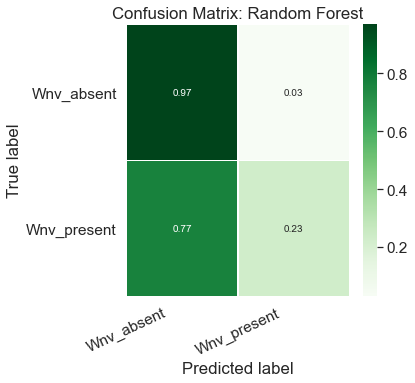

In [108]:
rf = RandomForestClassifier(n_estimators = 10, 
                           random_state = 42,
                           max_depth = 50, 
                           class_weight = dict({1:48, 0:1}),
                           verbose = 2)
rf.fit(X_train, y_train)
y_pred1 = rf.predict(X_test)

print("Features", rf.feature_importances_)
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title("Feat importance")
plt.barh(range(len(indices)), importances[indices],
        color = 'b', align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("relative importance")
plt.show()

roc1 = roc_auc_score(y_test, y_pred1)
roc1

print(confusion_matrix(y_test, y_pred1))
matrix = confusion_matrix(y_test, y_pred1)
matrix = matrix.astype("float") / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize=(5,5))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot = True, annot_kws = {"size":10},
           cmap = plt.cm.Greens, linewidths = 0.2)

class_names = ["Wnv_absent", "Wnv_present"]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation = 25)
plt.yticks(tick_marks2, class_names, rotation = 0)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix: Random Forest")
plt.show()

In [109]:
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

xgb = XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, 
                    scale_pos_weight=49, random_state = 42, verbosity=2,
                    n_jobs=-1, oob_score=True)

xgb.fit(X_train, y_train)
y_pred3 = xgb.predict(X_test)
roc3 = roc_auc_score(y_test, y_pred3)
roc3

[14:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "oob_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:25:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=21
[14:25:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:25:37] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prun

0.6908756684491979

[[2713  279]
 [  84   76]]


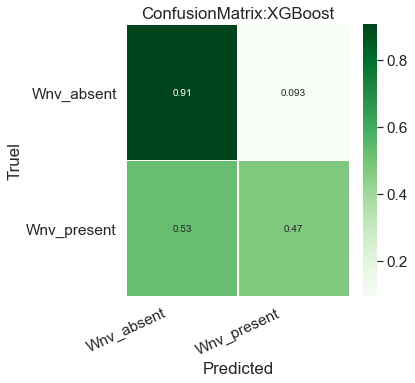

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2992
           1       0.21      0.47      0.30       160

    accuracy                           0.88      3152
   macro avg       0.59      0.69      0.62      3152
weighted avg       0.93      0.88      0.90      3152



In [110]:
print(confusion_matrix(y_test, y_pred3))
matrix = confusion_matrix(y_test, y_pred3)
matrix = matrix.astype("float") / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize = (5,5))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot = True, annot_kws = {"size":10},
           cmap = plt.cm.Greens, linewidths = 0.2)

tickmarks = np.arange(len(class_names))
tickmarks2 = tickmarks + 0.5
plt.xticks(tickmarks, class_names, rotation = 25)
plt.yticks(tickmarks2, class_names, rotation = 0)
plt.xlabel("Predicted")
plt.ylabel("Truel")
plt.title("ConfusionMatrix:XGBoost")
plt.show()

print(classification_report(y_test, y_pred3))

0.6908756684491979


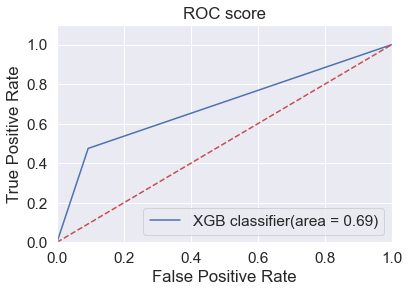

In [111]:
roc3 = roc_auc_score(y_test, y_pred3)
print(roc3)
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)

#plt.figure(figsize = (5,5))
plt.plot(fpr, tpr, label = "XGB classifier(area = %0.2f)" % roc3)
plt.plot([0,1],[0,1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC score")
plt.legend(loc = "lower right")
plt.show()

In [112]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, \
                       model, param_grid, cv=10, scoring_fit='roc_auc', do_probabilities=False):
                       #model, param_grid, cv=10, scoring_fit='ne_mean_squared_error', do_probabilities=False):
                       
    gs = GridSearchCV(estimator=model, \
                      param_grid=param_grid, \
                      cv=cv, \
                      n_jobs=-1, \
                      scoring=scoring_fit, \
                      verbose=2)
    
    fitted_model = gs.fit(X_train, y_train)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test)
    else:
        pred = fitted_model.predict(X_test)
    return fitted_model, pred

In [113]:
param_grid = {
            "eta": [0.01, 0.05, 0.1],
            "max_depth": [9,10,11],
            "scale_pos_weight": [49,50,51],
            "grow_policy":["depthwise", "losswise"]
             }

model = XGBClassifier(n_jobs = -1, random_state = 42, verbosity = 2)

In [114]:
model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, 
                                model, param_grid, cv = 5,
                                scoring_fit = "roc_auc")

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   47.3s finished


[14:26:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=9
[14:26:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:26:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=9
[14:26:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=9
[14:26:25] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=9
[1

[14:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=9
[14:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=9
[14:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=9
[14:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=9
[14:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=9
[14:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nod

In [115]:
print(model.best_score_)
print(model.best_params_)

0.8521554937773004
{'eta': 0.05, 'grow_policy': 'depthwise', 'max_depth': 9, 'scale_pos_weight': 51}


In [116]:
xgb = XGBClassifier(eta = 0.05, max_delta_step = 4, max_depth = 9, grow_policy = "depthwise",
                   scoring_fit = "roc_auc", scale_pos_weight = 51, n_jobs = -1)
xgb.fit(X_train, y_train)

[14:26:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring_fit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=9
[14:26:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:26:26] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_pru

[14:26:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=9
[14:26:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=9
[14:26:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=9
[14:26:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=9
[14:26:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=9
[14:26:27] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 176 extra nod

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.05, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=4, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=51, scoring_fit='roc_auc', subsample=1,
              tree_method='exact', validate_parameters=1, ...)

test 0.7351102941176471


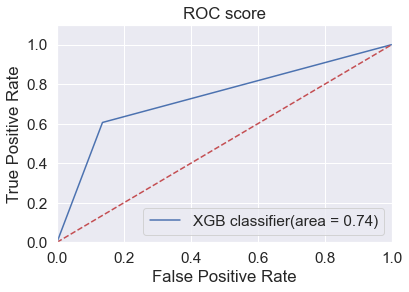

In [117]:
y_pred = xgb.predict(X_test)

roc = roc_auc_score(y_test, y_pred)
print("test", roc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, label = "XGB classifier(area = %0.2f)" % roc)
plt.plot([0,1],[0,1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC score")
plt.legend(loc = "lower right")
plt.show()

[[2585  407]
 [  63   97]]


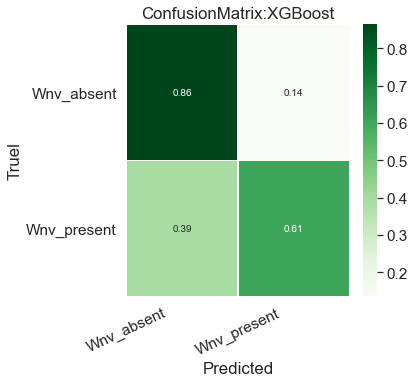

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2992
           1       0.21      0.47      0.30       160

    accuracy                           0.88      3152
   macro avg       0.59      0.69      0.62      3152
weighted avg       0.93      0.88      0.90      3152



In [118]:
y_pred = pred
print(confusion_matrix(y_test, y_pred))
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize = (5,5))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot = True, annot_kws = {"size":10},
           cmap = plt.cm.Greens, linewidths = 0.2)

tickmarks = np.arange(len(class_names))
tickmarks2 = tickmarks + 0.5
plt.xticks(tickmarks, class_names, rotation = 25)
plt.yticks(tickmarks2, class_names, rotation = 0)
plt.xlabel("Predicted")
plt.ylabel("Truel")
plt.title("ConfusionMatrix:XGBoost")
plt.show()

print(classification_report(y_test, y_pred3))

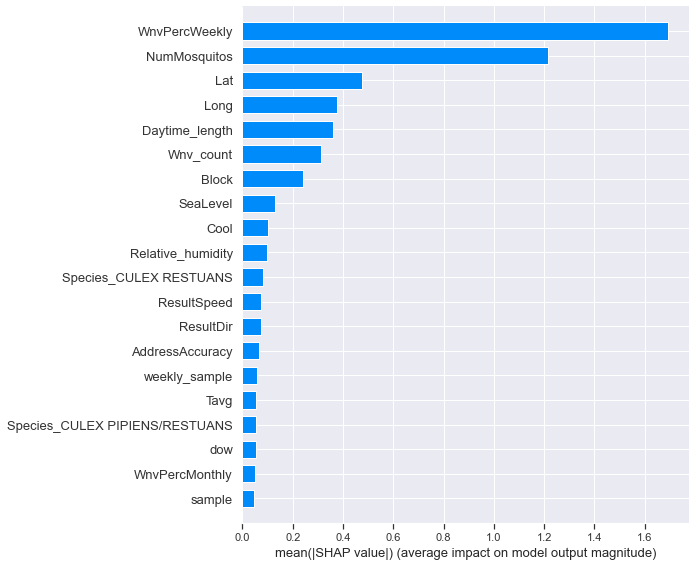

In [119]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type = "bar")

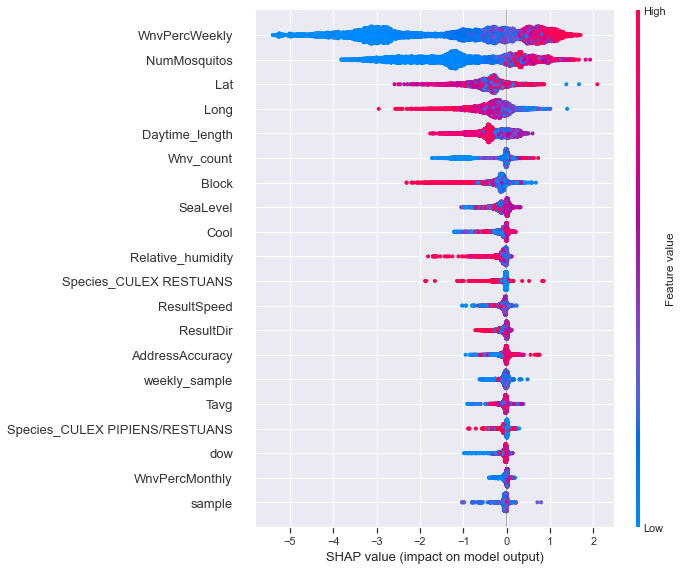

In [120]:
shap.summary_plot(shap_values, X_train)

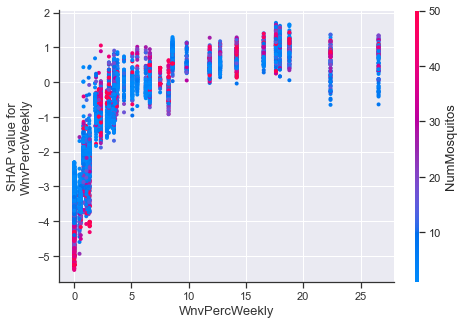

In [121]:
shap.dependence_plot("WnvPercWeekly", shap_values, X_train)

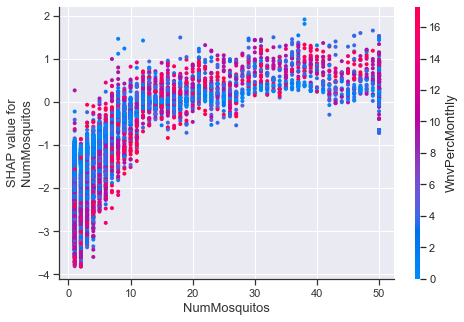

In [122]:
shap.dependence_plot("NumMosquitos", shap_values, X_train)

In [123]:
v_df = df_encoded[df_encoded.WnvPresent == 1]
nv_df = df_encoded[df_encoded.WnvPresent == 0]

print(v_df.shape)
print(nv_df.shape)

nv_df_partial = nv_df.sample(n = v_df.shape[0])
print(nv_df_partial.shape)

equal_sample = pd.concat([v_df, nv_df_partial])

(551, 37)
(9955, 37)
(551, 37)


In [124]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(equal_sample.drop(columns = "WnvPresent"),
                                                    equal_sample.WnvPresent, test_size = 0.3,
                                                       random_state = 41)

In [125]:
final_iv, IV = data_vars(X_train2, y_train2)

Block
0   -0.139416
1    0.150050
dtype: float64
Lat
0   -0.157046
1    0.161338
dtype: float64
Long
0    0.458523
1   -0.177637
2   -0.279563
dtype: float64
AddressAccuracy
0   -0.011181
1    0.019073
dtype: float64
NumMosquitos
0   -1.990016
1   -0.325518
2    1.061727
3    1.198640
dtype: float64
Daytime_length
0    -1.709113
1    -0.044106
2     0.300735
3     0.776875
4     1.647570
5     0.194305
6     1.299629
7          NaN
8     1.224406
9     1.433996
10    0.312569
11    1.411182
12   -0.407011
13    0.032855
14   -0.703351
15   -0.380578
16   -2.659065
17        -inf
18        -inf
dtype: float64
Heat
0    0.087553
1   -1.240356
dtype: float64
Cool
0   -0.156145
1    0.179038
dtype: float64
SeaLevel
0    0.162509
1   -0.182065
dtype: float64
ResultSpeed
0    0.332203
1   -0.044106
2   -0.341357
dtype: float64
ResultDir
0    -0.081846
1     1.565332
2     0.215405
3    -1.343389
4     0.803192
5    -0.737253
6    -2.569834
7     0.522290
8     0.448371
9    -0.255415
10    0

In [126]:
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
X2 = X_train2[features]
display(X2.shape)
X2.head()


X12 = X2._get_numeric_data()
final_df2, final_vif2 = iterate_vif(X12)

(771, 24)

Iteration # 1
Removing Long with VIF of 1749489.029978
Iteration # 2
Removing year with VIF of 408304.127842
Iteration # 3
Removing SeaLevel with VIF of 80472.175926
Iteration # 4
Removing Lat with VIF of 2134.670449
Iteration # 5
Removing Tavg with VIF of 660.503198
Iteration # 6
Removing WnvPercYearly with VIF of 108.750500
Iteration # 7
Removing week with VIF of 106.122998
Iteration # 8
Removing Relative_humidity with VIF of 42.586035
Iteration # 9
Removing WnvSample with VIF of 20.290211
Iteration # 10
Removing Species_CULEX PIPIENS/RESTUANS with VIF of 10.706828
Iteration # 11
Removing sample with VIF of 8.553859
Iteration # 12
Removing ResultSpeed with VIF of 5.668468
Iteration # 13
Removing dow with VIF of 5.124656
Iteration # 14
Complete


In [127]:
X_train2 = final_df2
print(len(X_train2.columns))
print(X_train2.columns)

11
Index(['Block', 'Cool', 'Heat', 'ResultDir', 'Species_CULEX PIPIENS',
       'Species_CULEX RESTUANS', 'WnvPercSeasonal', 'month_Aug', 'month_July',
       'month_June', 'month_Oct'],
      dtype='object')


In [128]:
X_test2 = X_test2[X_train2.columns]

In [129]:
param_grid = {'eta': [0.01, 0.05, 0.1], \
              'max_depth': [9, 10, 11], \
              'scale_pos_weight': [49, 50, 51], \
              'max_delta_step': [4, 6, 8], \
              'grow_policy':['depthwise', 'losswise']}

#model = XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state = 42, verbosity=2)
model = XGBClassifier(n_jobs=-1, random_state = 42, verbosity=2)

model, pred = algorithm_pipeline(X_train2, X_test2, y_train2, y_test2, 
                                 model, param_grid, cv=5, scoring_fit='roc_auc')


Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 629 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:   26.3s finished


[14:27:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:27:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:27:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:27:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 28 extra nodes, 0 pruned nodes, max_depth=9
[14:27

In [130]:
print(model.best_score_)
print(model.best_params_)

0.8271517108252617
{'eta': 0.05, 'grow_policy': 'depthwise', 'max_delta_step': 4, 'max_depth': 9, 'scale_pos_weight': 51}


In [131]:
xgb = XGBClassifier(eta=0.05, max_delta_step=4, max_depth=11,
                    grow_policy='depthwise',scoring_fit='roc_auc',
                    scale_pos_weight=51, n_jobs=-1, random_state = 42, verbosity=2)
xgb.fit(X_train2, y_train2)

[14:27:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "scoring_fit" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:27:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_prune.cc:101: tree pruning end, 30 extra nodes, 0 pruned nodes, max_depth=10
[14:27:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:27:02] INFO: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/tree/updater_pru

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.05, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0500000007, max_delta_step=4, max_depth=11,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=51, scoring_fit='roc_auc', subsample=1,
              tree_method='exact', validate_parameters=1, ...)

In [132]:
y_pred2 = xgb.predict(X_test2)
roc = roc_auc_score(y_test2, y_pred2)
print("ROC", roc)

ROC 0.6960978109671279


[[ 76  98]
 [  7 150]]


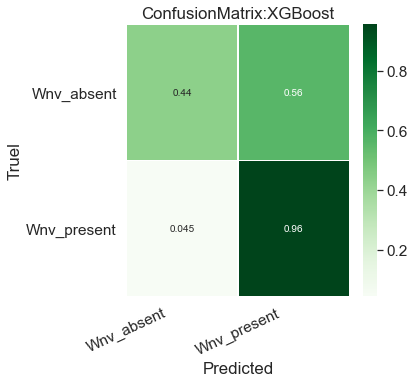

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2992
           1       0.21      0.47      0.30       160

    accuracy                           0.88      3152
   macro avg       0.59      0.69      0.62      3152
weighted avg       0.93      0.88      0.90      3152



In [133]:
print(confusion_matrix(y_test2, y_pred2))
matrix = confusion_matrix(y_test2, y_pred2)
matrix = matrix.astype("float") / matrix.sum(axis = 1)[:, np.newaxis]

plt.figure(figsize = (5,5))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, annot = True, annot_kws = {"size":10},
           cmap = plt.cm.Greens, linewidths = 0.2)

tickmarks = np.arange(len(class_names))
tickmarks2 = tickmarks + 0.5
plt.xticks(tickmarks, class_names, rotation = 25)
plt.yticks(tickmarks2, class_names, rotation = 0)
plt.xlabel("Predicted")
plt.ylabel("Truel")
plt.title("ConfusionMatrix:XGBoost")
plt.show()

print(classification_report(y_test, y_pred3))

ROC 0.6960978109671279


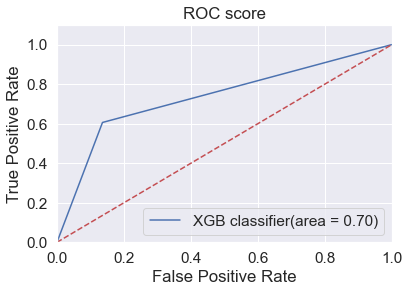

In [134]:
roc = roc_auc_score(y_test2, y_pred2)
print("ROC", roc)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, label = "XGB classifier(area = %0.2f)" % roc)
plt.plot([0,1],[0,1], "r--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC score")
plt.legend(loc = "lower right")
plt.show()

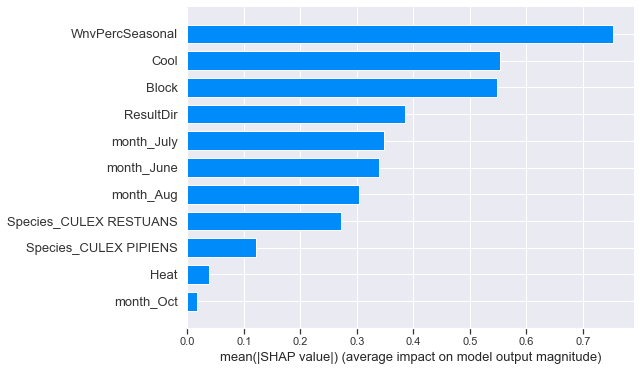

In [135]:
shap_values = shap.TreeExplainer(xgb).shap_values(X_train2)
shap.summary_plot(shap_values, X_train2, plot_type = "bar")

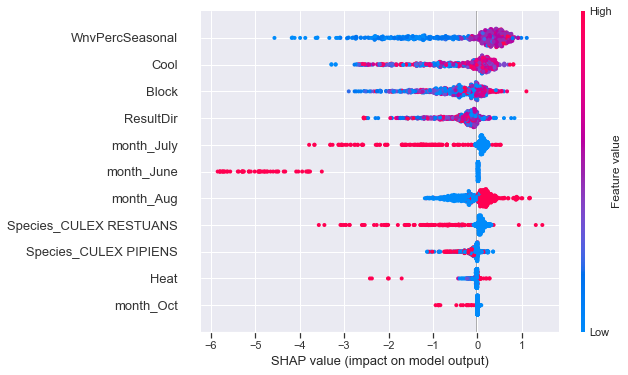

In [136]:
shap.summary_plot(shap_values, X_train2)